### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast

Possible TODOs:
- after writing summaries, could parallelize some stuff, topic analysis, ratings
- could also add tools to check format
- rewrite using an critic-refine flow, although one rewrite does an OK job
- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_const import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SCREENSHOT_DIR, SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

In [ ]:
before_date = None
# before_date = '2025-04-26 08:00'
do_download = False

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-04-29 11:39:23,722 - AInewsbot - INFO - Initializing with before_date=2025-04-28 18:00, do_download=False, thread_id=101a5ac1925a4f53b06c6d6c8af11c5e


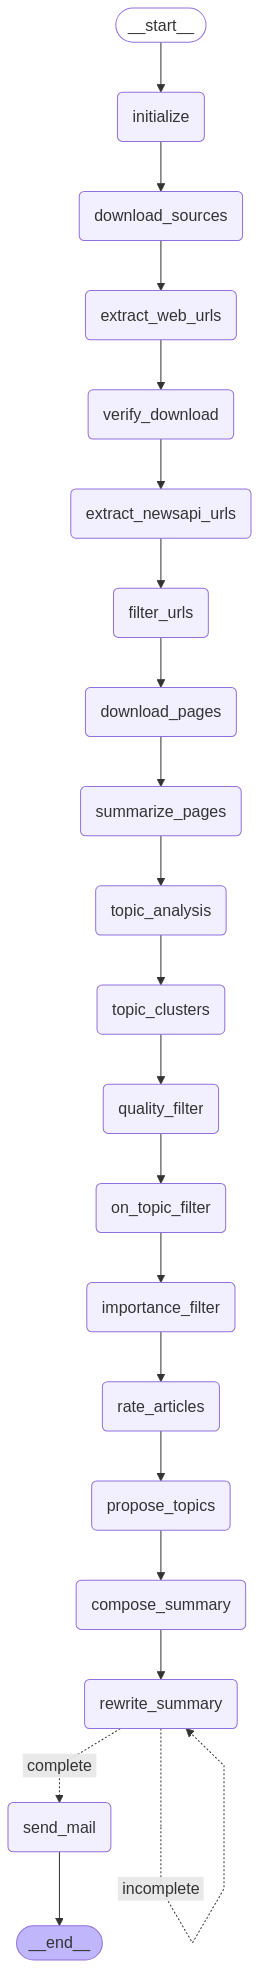

In [4]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-04-28 18:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [ ]:
lg_state = lg_agent.initialize_config(lg_state)


In [ ]:
lg_state = lg_agent.download_sources(lg_state)


In [ ]:
lg_state = lg_agent.extract_web_urls(lg_state)


In [ ]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
lg_state = lg_agent.verify_download(lg_state)


In [ ]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


In [ ]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


In [ ]:
lg_state = lg_agent.download_pages(lg_state)


In [7]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-04-29 11:39:42,120 - AInewsbot - INFO - Starting summarize
2025-04-29 11:39:42,124 - AInewsbot - INFO - Fetching summaries for all articles
2025-04-29 11:39:42,166 - AInewsbot - INFO - clean_html - Page title: OpenAI CEO says ChatGPT is "annoying" after its recent update | Windows Central
Social card title: OpenAI CEO Sam Altman says ChatGPT "glazes too much" with sycophantic tendencies, but a fix is coming.
Social card description: Multiple users have raised concerns about ChatGPT's new update that "glazes" with too much praise for the user.



htmlpages/GPT4os_update_is_absurdly_dangerous_to_release_to_a_billion_active_users___Even_OpenAI_CEO_Sam_Altman_admits_ChatGPT_is__too_sycophant-y___but_a_fix_is_on_the_way.html


2025-04-29 11:39:42,334 - AInewsbot - INFO - Queuing 0: Page title: OpenAI CEO says ChatGPT is "annoying" ...
2025-04-29 11:39:42,539 - AInewsbot - INFO - clean_html - Page title: 'Godfather Of AI' Reveals The Odds Of Humanity Being Overrun By Machines
Social card title: 'Godfather Of AI' Reveals The Odds Of Humanity Being Overrun By Machines
Social card description: Geoffrey Hinton, the 'godfather of AI', said this month that there's a 10 to 20 per cent chance that artificial intelligence takes over humanity.



htmlpages/Godfather_Of_AI__Reveals_The_Odds_Of_Humanity_Being_Overrun_By_Machines.html


2025-04-29 11:39:42,605 - AInewsbot - INFO - Queuing 1: Page title: 'Godfather Of AI' Reveals The Odds Of ...
2025-04-29 11:39:42,610 - AInewsbot - INFO - clean_html - Page title: 1 Artificial Intelligence (AI) Powerhouse That Could Crush Earnings Expectations Next Month
Social card title: 1 Artificial Intelligence (AI) Powerhouse That Could Crush Earnings Expectations Next Month
Social card description: In This Article:
Nvidia (NASDAQ: NVDA) has a strong history of beating analyst expectations for quarterly earnings and sales. The company has beaten estimates…

2025-04-29 11:39:42,615 - AInewsbot - INFO - Queuing 2: Page title: 1 Artificial Intelligence (AI) Powerho...
2025-04-29 11:39:42,641 - AInewsbot - INFO - clean_html - Page title: A Coding Guide to Different Function Calling Methods to Create Real-Time, Tool-Enabled Conversational AI Agents - MarkTechPost
Social card title: A Coding Guide to Different Function Calling Methods to Create Real-Time, Tool-Enabled Conversational AI 

htmlpages/1_Artificial_Intelligence__AI__Powerhouse_That_Could_Crush_Earnings_Expectations_Next_Month.html
htmlpages/A_Coding_Guide_to_Different_Function_Calling_Methods_to_Create_Real-Time__Tool-Enabled_Conversational_AI_Agents.html
htmlpages/AI_Lifecycle_Automation_Leader_ModelOp_Strengthens_Its_Commitment_to_Trustworthy_and_Ethical_AI_in_Healthcare_by_Joining_the_Coalition_for_Health_AI__CHAI.html
htmlpages/AI_Startup_Nscale_Chases_ByteDance_Deal_and__1.8_Billion_in_Debt.html


2025-04-29 11:39:42,836 - AInewsbot - INFO - Queuing 5: Page title: AI Startup Nscale Chases ByteDance Dea...
2025-04-29 11:39:42,872 - AInewsbot - INFO - clean_html - Page title: AI solves 100-year-old mystery to supercharge scientific discovery | The Independent
Social card title: AI solves 100-year-old mystery to supercharge scientific discovery
Social card description: Breakthrough AI model could help advance everything from ultra-powerful batteries, to archaeology

2025-04-29 11:39:42,928 - AInewsbot - INFO - Queuing 6: Page title: AI solves 100-year-old mystery to supe...
2025-04-29 11:39:42,947 - AInewsbot - INFO - clean_html - Page title: AI suggestions make writing more generic and Western, study finds
Social card title: AI suggestions make writing more generic and Western, study finds
Social card description: Artificial intelligence-based writing assistants are popping up everywhere—from phones to email apps to social media platforms.

2025-04-29 11:39:42,964 - AInewsbot - IN

htmlpages/AI_solves_100-year-old_mystery_to_supercharge_scientific_discovery.html
htmlpages/AI_suggestions_make_writing_more_generic_and_Western__study_finds.html
htmlpages/AI-generated_code_could_be_a_disaster_for_the_software_supply_chain._Heres_why..html
htmlpages/Agentic_AI__The_Next_Step_For_Enterprise_AI_And_Why_It_Matters.html


2025-04-29 11:39:43,055 - AInewsbot - INFO - Queuing 9: Page title: Agentic AI: The Next Step For Enterpri...
2025-04-29 11:39:43,057 - AInewsbot - INFO - clean_html - Page title: Bloomberg - Are you a robot?

2025-04-29 11:39:43,059 - AInewsbot - INFO - Queuing 10: Page title: Bloomberg - Are you a robot?
To contin...
2025-04-29 11:39:43,095 - AInewsbot - INFO - clean_html - Page title: The deadline to book your exhibit table for TechCrunch Sessions: AI is May 9 | TechCrunch
Social card title: Alibaba unveils Qwen3, a family of 'hybrid' AI reasoning models | TechCrunch
Social card description: Chinese tech company Alibaba released Qwen 3, a family of AI models that the company claims outperforms some of the best.

2025-04-29 11:39:43,143 - AInewsbot - INFO - Queuing 11: Page title: The deadline to book your exhibit tabl...
2025-04-29 11:39:43,153 - AInewsbot - INFO - clean_html - Page title: Alibaba launches open source Qwen3 besting OpenAI o1 | VentureBeat
Social card title: Alibaba 

htmlpages/Alibaba_Rolls_Out_Latest_Flagship_AI_Model_in_Post-DeepSeek_Race.html
htmlpages/Alibaba_debuts_its_Qwen3_family_of_open-weight_hybrid_AI_reasoning_models__including_Qwen3-235B-A22B__with_235B_total_parameters_and_22B_activated_parameters.html
htmlpages/Alibaba_launches_open_source_Qwen3_model_that_surpasses_OpenAI_o1_and_DeepSeek_R1.html
htmlpages/Americans_largely_foresee_AI_having_negative_effects_on_news__journalists.html
htmlpages/Apiiro_debuts_dynamic_software_mapping_to_streamline_vulnerability_management.html
htmlpages/ChatGPT_goes_shopping_with_new_product-browsing_feature.html


2025-04-29 11:39:43,266 - AInewsbot - INFO - clean_html - Page title: ChatGPT goes shopping with new product-browsing feature - Ars Technica
Social card title: ChatGPT goes shopping with new product-browsing feature
Social card description: ChatGPT will now recommend products to be bought offsite—but no sponsored ads just yet.

2025-04-29 11:39:43,283 - AInewsbot - INFO - Queuing 15: Page title: ChatGPT goes shopping with new product...
2025-04-29 11:39:43,284 - AInewsbot - INFO - clean_html - Page title: wsj.com

2025-04-29 11:39:43,374 - trafilatura.core - WARNING - discarding data: None
2025-04-29 11:39:43,374 - AInewsbot - INFO - Queuing 16: Page title: wsj.com
...
2025-04-29 11:39:43,387 - AInewsbot - INFO - clean_html - Page title: China’s Huawei ‘Hoping Its New AI Chip Can Outpower Nvidia’
Social card title: China’s Huawei ‘Hoping Its New AI Chip Can Outpower Nvidia’
Social card description: Chinese tech giant Huawei is getting ready to test its new and most powerful artificial 

htmlpages/China_s_Pony.ai_says_it_can_now_build_its_most_advanced_autonomous_driving_system_for_70__less_and_plans_to_start_mass_production_of_its_robotaxis_in_mid-2025.html
htmlpages/Chinas_Huawei_Hoping_Its_New_AI_Chip_Can_Outpower_Nvidia.html
htmlpages/Could_100_Men_Really_Take_on_One_Gorilla_and_Win__We_Asked_ChatGPT.html
htmlpages/Could_Data_Center_Demand_Spark_A_Climate_Tech_Rebound.html


2025-04-29 11:39:43,521 - AInewsbot - INFO - clean_html - Page title: Could Data Center Demand Spark A Climate Tech Rebound?
Social card title: Could Data Center Demand Spark A Climate Tech Rebound?
Social card description: Energy credit frameworks and investment in AI chip efficiency could spur breakthroughs in new climate tech solutions

2025-04-29 11:39:43,578 - AInewsbot - INFO - Queuing 19: Page title: Could Data Center Demand Spark A Clima...
2025-04-29 11:39:43,614 - AInewsbot - INFO - clean_html - Page title: Could Data Center Demand Spark A Climate Tech Rebound?
Social card title: Could Data Center Demand Spark A Climate Tech Rebound?
Social card description: Energy credit frameworks and investment in AI chip efficiency could spur breakthroughs in new climate tech solutions

2025-04-29 11:39:43,660 - AInewsbot - INFO - Queuing 20: Page title: Could Data Center Demand Spark A Clima...
2025-04-29 11:39:43,673 - AInewsbot - INFO - clean_html - Page title: Darcula Phishing Kit Use

htmlpages/Could_Data_Centre_Demand_Spark_A_Climate_Tech_Rebound.html
htmlpages/Darcula_Phishing_Kit_Uses_AI_to_Evade_Detection__Experts_Warn.html
htmlpages/Deepfake_Revenge_Porn_Bill_Heads_to_Trump_for_His_Signature.html
htmlpages/Digital_twins_critical_for_digital_transformation_to_fly_in_aerospace.html
htmlpages/Dow_Jones_Futures_Dip_As_Nvidia_Slides_On_New_China_AI_Chip__Tesla_Extends_Rally.html
htmlpages/Dr._Google_Starts_Sharing_Regular_Folks_Advice_As_Chatbots_Loom.html


2025-04-29 11:39:43,798 - AInewsbot - INFO - Queuing 25: Page title: Dr. Google Starts Sharing Regular Folk...
2025-04-29 11:39:43,816 - AInewsbot - INFO - clean_html - Page title: DuckDuckGO AI lets you switch AI models mid-conversation
Social card title: DuckDuckGO AI lets you switch AI models mid-conversation
Social card description: DuckDuckGO just updated its AI feature to let you switch models mid-conversation, ensuring you always get the best answer.

2025-04-29 11:39:43,833 - AInewsbot - INFO - Queuing 26: Page title: DuckDuckGO AI lets you switch AI model...
2025-04-29 11:39:43,853 - AInewsbot - INFO - clean_html - Page title: Duolingo will replace contract workers with AI | The Verge
Social card title: Duolingo will replace contract workers with AI
Social card description: Duolingo is making some AI-focused changes.

2025-04-29 11:39:43,885 - AInewsbot - INFO - Queuing 27: Page title: Duolingo will replace contract workers...
2025-04-29 11:39:43,906 - AInewsbot - INFO - clean

htmlpages/DuckDuckGO_AI_lets_you_switch_AI_models_mid-conversation.html
htmlpages/Duolingo_will_replace_contract_workers_with_AI._The_company_is_going_to_be_AI-first__says_its_CEO..html
htmlpages/Duolingo_s_CEO_lays_out_5_ways_AI_will_be_used_to_decide_the_future_of_its_workforce.html
htmlpages/Eugene_Kaspersky_sounds_alarm_on_AI-driven_cybercrime_outpacing_traditional_defences__urges_rethink.html


2025-04-29 11:39:44,001 - AInewsbot - INFO - Queuing 29: Page title: Eugene Kaspersky sounds alarm on AI-dr...
2025-04-29 11:39:44,207 - AInewsbot - INFO - clean_html - Page title: Ex-OpenAI CEO and power users sound alarm over AI sycophancy and flattery of users | VentureBeat
Social card title: Ex-OpenAI CEO and power users sound alarm over AI sycophancy and flattery of users
Social card description: Crucially, the turbulence also nudges many organizations to explore open-source models they can host, monitor, and fine-tune themselves.



htmlpages/Ex-OpenAI_CEO_and_power_users_sound_alarm_over_AI_sycophancy_and_flattery_of_users.html


2025-04-29 11:39:44,219 - AInewsbot - INFO - Queuing 30: Page title: Ex-OpenAI CEO and power users sound al...
2025-04-29 11:39:44,237 - AInewsbot - INFO - clean_html - Page title: Exclusive: Camp Network raises $25 million to help firms collect AI copyright royalties using blockchain | Fortune Crypto
Social card title: Exclusive: Camp Network raises $25 million to help firms collect AI copyright royalties using blockchain
Social card description: 1kx and Blockchain Capital both led the Series A, which valued the startup at up to $400 million.

2025-04-29 11:39:44,265 - AInewsbot - INFO - Queuing 31: Page title: Exclusive: Camp Network raises $25 mil...
2025-04-29 11:39:44,275 - AInewsbot - INFO - clean_html - Page title: Exclusive: What if AI could design a jet engine—or even a starship? Google DeepMind and Airbus veterans just raised $23M with an eye on that future
Social card title: Exclusive: What if AI could design a jet engine—or even a starship? Google DeepMind and Airbus vetera

htmlpages/Exclusive__Camp_Network_raises__25_million_to_help_firms_collect_AI_copyright_royalties_using_blockchain.html
htmlpages/Exclusive__What_If_AI_could_design_a_jet_engineor_even_a_starship__Google_DeepMind_and_Airbus_veterans_just_raised__23M_with_an_eye_on_that_future.html
htmlpages/Finding_Your_Edge_in_a_World_of_Automated_Content.html
htmlpages/Firms_are_still_struggling_to_find_out_what_agentic_AI_can_achieve_-_Tech_Monitor.html
htmlpages/Future_weapons__Battlefield_AI.html
htmlpages/Gaussian_Splatting_Meets_ROS2.html


2025-04-29 11:39:44,439 - AInewsbot - INFO - clean_html - Page title: GitHub - shadygm/ROSplat: The Online ROS2-Based Gaussian Splatting-Enabled Visualizer
Social card title: GitHub - shadygm/ROSplat: The Online ROS2-Based Gaussian Splatting-Enabled Visualizer
Social card description: The Online ROS2-Based Gaussian Splatting-Enabled Visualizer - shadygm/ROSplat

2025-04-29 11:39:44,463 - AInewsbot - INFO - Queuing 36: Page title: GitHub - shadygm/ROSplat: The Online R...
2025-04-29 11:39:44,476 - AInewsbot - INFO - clean_html - Page title: Generative AI is not replacing jobs or hurting wages at all • The Register
Social card title: Generative AI is not replacing jobs or hurting wages at all
Social card description: : 'When we look at the economic outcomes, it really has not moved the needle'

2025-04-29 11:39:44,500 - AInewsbot - INFO - Queuing 37: Page title: Generative AI is not replacing jobs or...
2025-04-29 11:39:44,518 - AInewsbot - INFO - clean_html - Page title: Generative AI i

htmlpages/Generative_AI_is_not_replacing_jobs_or_hurting_wages_at_all__say_economists.html
htmlpages/Generative_AI_isn_t_biting_into_wages__replacing_workers__and_isn_t_saving_time__economists_say.html
htmlpages/Godfather_of_AI_says_AI_is_like_a_cute_tiger_cubunless_you_know_it_wont_turn_on_you__you_should_worry.html
htmlpages/Google_DeepMind_Workers_To_Unionise_Over_AI_Sales_To_Israeli_Defence_Groups.html
htmlpages/Google_Photos_Has_a_Hidden_Shortcut_That_Switches_from_Ask_Photos_to_Classic_Search.html


2025-04-29 11:39:44,677 - AInewsbot - INFO - clean_html - Page title: Google Photos Has a Hidden Shortcut That Switches from Ask Photos to Classic Search | Technology News
Social card title: This Secret Shortcut Brings the Classic Search Back on Google Photos
Social card description: If you pay for Gemini Advanced but don't like the Ask Photos feature, here's how to being the classic search feature back with a couple of taps.

2025-04-29 11:39:44,756 - AInewsbot - INFO - Queuing 41: Page title: Google Photos Has a Hidden Shortcut Th...
2025-04-29 11:39:44,785 - AInewsbot - INFO - clean_html - Page title: How Companies Can Turn AI Disruption Into Competitive Advantage
Social card title: How Companies Can Turn AI Disruption Into Competitive Advantage
Social card description: In an AI-driven economy, companies must go beyond reacting to disruption. They need to become organizations capable of turning uncertainty into a strategic advantage.

2025-04-29 11:39:44,824 - AInewsbot - INFO - Que

htmlpages/How_Companies_Can_Turn_AI_Disruption_Into_Competitive_Advantage.html
htmlpages/How_an__internet_of_agents__could_help_AIs_connect_and_work_together.html
htmlpages/How_to_Earn__350_a_Month_From_Your_GPU_With_Sogni_and_Salad.html
htmlpages/Huawei_Races_To_Replace_Nvidia__New_Ascend_910D_AI_Chip_Will_Begin_Testing_Next_Month_In_China.html
htmlpages/Humanoid_Robots__A_New_Frontier_In_Technology_Investments.html


2025-04-29 11:39:44,982 - AInewsbot - INFO - Queuing 46: Page title: Humanoid Robots: A New Frontier In Tec...
2025-04-29 11:39:45,081 - AInewsbot - INFO - clean_html - Page title: I gave the “create a replica of this image 70 times” thing a try : ChatGPT
Social card title: I gave the “create a replica of this image 70 times” thing a try
Social card description: I used the exact same prompt as the original poster. Didn’t go to 75 images like they did out of laziness, sorry :P I did create 71 images...

2025-04-29 11:39:45,183 - AInewsbot - INFO - Queuing 47: Page title: I gave the “create a replica of this i...


htmlpages/I_gave_the_create_a_replica_of_this_image_70_times_thing_a_try.html


2025-04-29 11:39:45,203 - AInewsbot - INFO - clean_html - Page title: I Work in Tech, but I Fear AI—how I Teach My Daughter to Stay Safe   - Business Insider
Social card title: I'm a mom who works in tech, and AI scares me. I taught my daughter these simple guidelines to spot fake content.
Social card description: Although I work in tech, I'm very wary of AI. To help protect my daughter, I'm teaching her how to detect fake content and how to fact-check.

2025-04-29 11:39:45,223 - AInewsbot - INFO - Queuing 48: Page title: I Work in Tech, but I Fear AI—how I Te...
2025-04-29 11:39:45,242 - AInewsbot - INFO - clean_html - Page title: Implement Flash Attention Backend in SGLang - Basics and KV Cache · Biao's Blog
Social card title: Biao's Blog
Social card description: A blog about my thoughts on ML Sys and LLMs

2025-04-29 11:39:45,302 - AInewsbot - INFO - Queuing 49: Page title: Implement Flash Attention Backend in S...


htmlpages/I_m_a_mom_who_works_in_tech__and_AI_scares_me._I_taught_my_daughter_these_simple_guidelines_to_spot_fake_content..html
htmlpages/Implement_Flash_Attention_Back_End_in_SGLang__Basics_and_KV_Cache.html
htmlpages/Improving_Privacy_Risk_Detection_with_Sequence_Labelling_and_Web_Search.html


2025-04-29 11:39:45,520 - AInewsbot - INFO - clean_html - Page title: Improving Privacy Risk Detection with Sequence Labelling and Web Search | HackerNoon
Social card title: Improving Privacy Risk Detection with Sequence Labelling and Web Search | HackerNoon
Social card description: Learn how sequence labelling and web search methods improve the accuracy of privacy risk detection by analyzing text spans and web search results.

2025-04-29 11:39:45,545 - AInewsbot - INFO - Queuing 50: Page title: Improving Privacy Risk Detection with ...
2025-04-29 11:39:45,556 - AInewsbot - INFO - clean_html - Page title: Instagram's AI Chatbots Lie About Being Licensed Therapists
Social card title: Instagram's AI Chatbots Lie About Being Licensed Therapists
Social card description: When pushed for credentials, Instagram's user-made AI Studio bots will make up license numbers, practices, and education to try to convince you it's qualified to help with your mental health.

2025-04-29 11:39:45,573 - AIne

htmlpages/Instagram_s_AI_Chatbots_Lie_About_Being_Licensed_Therapists.html
htmlpages/Intel_admits_what_we_all_knew__no_one_is_buying_AI_PCs.html
htmlpages/Jeffs_Brands_Launches_Forts_AI-Based_Pest_Control_App_on_the_Apple_App_Store.html
htmlpages/Larian_s_Swen_Vincke_says_AI-obsessed_studios_won_t__have_a_competitive_advantage___because_those_tools_are__gonna_be_what_s_available_to_everybody.html


2025-04-29 11:39:45,779 - AInewsbot - INFO - Queuing 54: Page title: Larian's Swen Vincke says AI-obsessed ...
2025-04-29 11:39:45,792 - AInewsbot - INFO - clean_html - Page title: Leadership Success Story: Saideep Nakka's Pioneer Innovation in Robotic Spine Surgery | HackerNoon
Social card title: Leadership Success Story: Saideep Nakka's Pioneer Innovation in Robotic Spine Surgery | HackerNoon
Social card description: Saideep Nakka led the first robot-guided spine surgery innovation, combining bone cutting and graft delivery, setting new standards for surgical robotics.

2025-04-29 11:39:45,815 - AInewsbot - INFO - Queuing 55: Page title: Leadership Success Story: Saideep Nakk...
2025-04-29 11:39:45,828 - AInewsbot - INFO - clean_html - Page title: How Gumroad Uses AI Coding to Boost Productivity by 40x - Geeky Gadgets
Social card title: Learn How Gumroad Achieved a 40x Productivity Boost with AI Coding Tools
Social card description: Discover how Gumroad achieved a 40x productivity bo

htmlpages/Leadership_Success_Story__Saideep_Nakka_s_Pioneer_Innovation_in_Robotic_Spine_Surgery.html
htmlpages/Learn_How_Gumroad_Achieved_a_40x_Productivity_Boost_with_AI_Coding_Tools.html
htmlpages/Mastercard_Gives_AI_Agents_the_Ability_to_Shop_on_Your_Behalf.html
htmlpages/Meet_OmniChat_AI__Winner_of_Startups_of_The_Year_2024_in_Austin__TX.html
htmlpages/Meta_AI_was_getting_explicit_with_underage_users.html
htmlpages/Meta_has_a_John_Cena-voiced_sex_chatbot_problem._It_s_a_risk_it_shouldn_t_take..html
htmlpages/Metas_ChatGPT_competitor_shows_how_your_friends_use_AI.html


2025-04-29 11:39:45,993 - AInewsbot - INFO - clean_html - Page title: Meta releases AI app to compete with ChatGPT | The Verge
Social card title: Meta’s ChatGPT competitor shows how your friends use AI
Social card description: What if Instagram only showed people talking with AI?

2025-04-29 11:39:46,028 - AInewsbot - INFO - Queuing 61: Page title: Meta releases AI app to compete with C...
2025-04-29 11:39:46,030 - AInewsbot - INFO - clean_html - Page title: Bloomberg - Are you a robot?

2025-04-29 11:39:46,032 - AInewsbot - INFO - Queuing 62: Page title: Bloomberg - Are you a robot?
To contin...
2025-04-29 11:39:46,052 - AInewsbot - INFO - clean_html - Page title: Microsoft could offer a guided tour of the Copilot app to help Windows 11 newbies, but I’m still waiting for the big changes to the AI assistant | TechRadar
Social card title: Microsoft could offer a guided tour of the Copilot app to help Windows 11 newbies, but I’m still waiting for the big changes to the AI assistant
Socia

htmlpages/Microsoft_and_Amazon_Capex_in_Focus_Amid_Potential_AI_Pullback.html
htmlpages/Microsoft_could_offer_a_guided_tour_of_the_Copilot_app_to_help_Windows_11_newbies__but_Im_still_waiting_for_the_big_changes_to_the_AI_assistant.html
htmlpages/Natasha_Lyonne_Set_to_Make_Feature_Directorial_Debut_With_AI_Film__With_Help_From_Jaron_Lanier__Exclusive.html
htmlpages/Nearly_6_out_of_10_workers_admit_making_AI-fueled_errors.html
htmlpages/New_Cloud_Security_Alliance_Certification_Program_Equips_Professionals_With_Skills_to_Ensure_Responsible_and_Safe_Development_and_Management_of_Artificial_Intelligence__AI.html
htmlpages/New_Research_from_LevelBlue_Indicates_How_AI_is_Challenging_Organizations_to_Rethink_Cyber_Resilience.html


2025-04-29 11:39:46,271 - AInewsbot - INFO - Queuing 67: Page title: New Research from LevelBlue Indicates ...
2025-04-29 11:39:46,289 - AInewsbot - INFO - clean_html - Page title: New standard developed for battery-free, AI-enabled IoT devices
Social card title: New standard developed for battery-free, AI-enabled IoT devices
Social card description: A landmark international collaboration led by Newcastle University has developed the world's most efficient integrated light-harvesting and storage system for powering autonomous Artificial Intelligence (AI) at the edge of the Internet of Things (IoT).

2025-04-29 11:39:46,305 - AInewsbot - INFO - Queuing 68: Page title: New standard developed for battery-fre...
2025-04-29 11:39:46,320 - AInewsbot - INFO - clean_html - Page title: Nvidia introduces DOCA Argus to bring real-time threat detection to AI infrastructure - SiliconANGLE
Social card title: Nvidia introduces DOCA Argus to bring real-time threat detection to AI infrastructure - Sili

htmlpages/New_standard_developed_for_battery-free__AI-enabled_IoT_devices.html
htmlpages/Nvidia_introduces_DOCA_Argus_to_bring_real-time_threat_detection_to_AI_infrastructure.html
htmlpages/Nvidias_Chip_Market_Problems_Arent_Just_in_China.html
htmlpages/OpenAI_Updates_GPT-4o_to_Boost_Intelligence_and_Personality__Faces_Unexpected_Side_Effects.html
htmlpages/OpenAI_adds_shopping_features_to_ChatGPT_Search.html


2025-04-29 11:39:46,483 - AInewsbot - INFO - Queuing 72: Page title: OpenAI adds shopping features to ChatG...
2025-04-29 11:39:46,512 - AInewsbot - INFO - clean_html - Page title: OpenAI adds shopping to ChatGPT — here's how it works
Social card title: OpenAI adds shopping to ChatGPT — here’s how it works
Social card description: ChatGPT will pull from sources including editorial commerce reviews as well as forums like Reddit to get a range of evaluations.

2025-04-29 11:39:46,553 - AInewsbot - INFO - Queuing 73: Page title: OpenAI adds shopping to ChatGPT — here...
2025-04-29 11:39:46,579 - AInewsbot - INFO - clean_html - Page title: The deadline to book your exhibit table for TechCrunch Sessions: AI is May 9 | TechCrunch
Social card title: OpenAI upgrades ChatGPT search with shopping features | TechCrunch
Social card description: OpenAI is updating ChatGPT Search to give users an improved shopping experience, the company announced in a blog post.

2025-04-29 11:39:46,610 - AInewsbot

htmlpages/OpenAI_adds_shopping_to_ChatGPT__heres_how_it_works.html
htmlpages/OpenAI_says_users_made_1B__web_searches_in_ChatGPT_last_week__adds_trending_searches__and_lets_WhatsApp_users_chat_1-800-ChatGPT_for_up-to-date_search_results.html
htmlpages/Outside_the_Box__The_Looking_Glass_World_of_AI_Revealed.html
htmlpages/Pioneering_AI_Innovation_in_Financial_Reconciliation__The_GenAI_Transformation_By_Akshat_Khemka.html


2025-04-29 11:39:46,704 - AInewsbot - INFO - Queuing 76: Page title: Pioneering AI Innovation in Financial ...


htmlpages/Recorded_Future_launches_Malware_Intelligence_to_automate_malware_detection_and_response.html


2025-04-29 11:39:46,912 - AInewsbot - INFO - clean_html - Page title: Recorded Future launches Malware Intelligence to automate malware detection and response - SiliconANGLE
Social card title: Recorded Future launches Malware Intelligence to automate malware detection and response - SiliconANGLE
Social card description: Recorded Future launches Malware Intelligence to automate malware detection and response - SiliconANGLE

2025-04-29 11:39:46,931 - AInewsbot - INFO - Queuing 77: Page title: Recorded Future launches Malware Intel...
2025-04-29 11:39:46,939 - AInewsbot - INFO - clean_html - Page title: Reddit Issuing 'Formal Legal Demands' Against Researchers Who Conducted Secret AI Experiment on Users
Social card title: Reddit Issuing 'Formal Legal Demands' Against Researchers Who Conducted Secret AI Experiment on Users
Social card description: Reddit called it an "improper and highly unethical experiment" and said it did not know it was happening.

2025-04-29 11:39:46,947 - AInewsbot -

htmlpages/Reddit_Issuing__Formal_Legal_Demands__Against_Researchers_Who_Conducted_Secret_AI_Experiment_on_Users.html
htmlpages/Researchers_asked_almost_50_000_people_how_they_use_AI._Over_half_of_workers_said_they_hide_it_from_their_bosses..html
htmlpages/Revolutionizing_AI_Security_and_Cyber_Resilience_with_Open-Source_Innovation_and_Risk_Management_Solutions.html
htmlpages/Robotics_for_software_engineers__humanoid_robots.html
None
htmlpages/SandboxAQ__Accelerating_drug_discovery_through_cloud_integration.html
htmlpages/Show_HN__Flowcode__Turing-complete_visual_programming_platform.html
htmlpages/Sources_detail_tensions_between_Sam_Altman_and_Satya_Nadella__whose_partnership_began_after_a_summer_2018_meeting__Microsoft_can_block_OpenAI_s_for-profit_move.html
htmlpages/Swiss_boffins_admit_to_secretly_posting_AI-penned_posts_to_Reddit_in_the_name_of_scienceTheyre_sorry_not_sorry_for_testing_if_bots_can_change_minds_by_pretending_to_be_a_trauma_counselor_or_a_victim_of_sexual_abuseAI___M

2025-04-29 11:39:47,147 - AInewsbot - INFO - Queuing 86: Page title: Swiss boffins admit having AI write Re...
2025-04-29 11:39:47,168 - AInewsbot - INFO - clean_html - Page title: Tap Into The Power Of Agentic AI
Social card title: Tap Into The Power Of Agentic AI
Social card description: Research from Cloudera found that 87% of organizations believe it’s important to invest in AI agents to maintain a competitive edge within their industry and transform business operations

2025-04-29 11:39:47,194 - AInewsbot - INFO - Queuing 87: Page title: Tap Into The Power Of Agentic AI
Socia...
2025-04-29 11:39:47,255 - AInewsbot - INFO - clean_html - Page title: Watch These Nvidia Price Levels as Stock Slips on News of Chinese Rival's AI Chip
Social card title: Watch These Nvidia Price Levels as Stock Slips on News of Chinese Rival's AI Chip
Social card description: Nvidia shares fell on Monday to snap a four-day winning streak following news that China's Huawei Technologies is developing a riva

htmlpages/Tap_Into_The_Power_Of_Agentic_AI.html
htmlpages/The_AI_data_center_race_is_slowing_down_as_Amazon_and_Microsoft_catch_their_breath.html
htmlpages/The_AI_opportunity_action_plan__a_blueprint_for_innovation__growth_and_global_competitiveness.html


2025-04-29 11:39:47,359 - AInewsbot - INFO - clean_html - Page title: The AI opportunity action plan: a blueprint for innovation, growth and global competitiveness | TechRadar
Social card title: The AI opportunity action plan: a blueprint for innovation, growth and global competitiveness
Social card description: Paving the future with Sovereign AI

2025-04-29 11:39:47,385 - AInewsbot - INFO - Queuing 89: Page title: The AI opportunity action plan: a blue...
2025-04-29 11:39:47,397 - AInewsbot - INFO - clean_html - Page title: The Best AI Courses For Marketers And Content Creators - eLearning Industry
Social card title: The Best AI Courses For Marketers And Content Creators Looking To Future-Proof Their Skills
Social card description: The best AI courses for marketers and content creators are waiting for you to leverage their benefits and help your career grow quickly.

2025-04-29 11:39:47,414 - AInewsbot - INFO - Queuing 90: Page title: The Best AI Courses For Marketers And ...
2025-04

htmlpages/The_Best_AI_Courses_For_Marketers_And_Content_Creators_Looking_To_Future-Proof_Their_Skills.html
htmlpages/The_Next_Frontier_of_Healthtech_Innovation__Transforming_Healthcare_with_AI__Telemedicine__and_Personalized_Care.html
None
htmlpages/The_deadline_to_book_your_exhibit_table_for_TechCrunch_Sessions__AI_is_May_9.html
htmlpages/There_s_a_growing_rift_between_Sam_Altman_and_Satya_Nadella__ndash__Microsoft_could_block_OpenAI_s_for-profit_restructuring.html
htmlpages/Three_insights_you_may_have_missed_from_theCUBEs_coverage_of_Dells_Is_Your_IT_Infrastructure_Ready_for_the_Age_of_AI__event.html
htmlpages/Tripp_launches_Kokua_AI_as_mental_wellness_coach_across_multiple_platforms.html


2025-04-29 11:39:47,600 - AInewsbot - INFO - Queuing 96: Page title: Tripp launches Kōkua AI as mental well...
2025-04-29 11:39:47,617 - AInewsbot - INFO - clean_html - Page title: Trump’s hasty Take It Down Act has “gaping flaws” that threaten encryption - Ars Technica
Social card title: Trump’s hasty Take It Down Act has “gaping flaws” that threaten encryption
Social card description: Legal challenges will likely immediately follow law’s passage, experts said.

2025-04-29 11:39:47,634 - AInewsbot - INFO - Queuing 97: Page title: Trump’s hasty Take It Down Act has “ga...
2025-04-29 11:39:47,668 - AInewsbot - INFO - clean_html - Page title: Turkish Distrib Başka Sinema To Theatrically Release AI Doc Post Truth
Social card title: Turkish Distributor Başka Sinema Sets Pioneering Theatrical Release For AI Doc ‘Post Truth’
Social card description: Turkish Distributor Başka Sinema Sets Pioneering Theatrical Release For AI Doc ‘Post Truth’

2025-04-29 11:39:47,707 - AInewsbot - INFO - Queuin

htmlpages/Trumps_hasty_Take_It_Down_Act_has_gaping_flaws_that_threaten_encryption.html
htmlpages/Turkish_Distributor_Baska_Sinema_Sets_Pioneering_Theatrical_Release_For_AI_Doc_Post_Truth.html
None
htmlpages/US_Predictive_Maintenance_Market_Surges_to__15.2_billion_by_2029_-_Led_by_IBM__US___AWS__US___Google__US___Microsoft__US.html
htmlpages/Unlocking_the_soundscape_of_coral_reefs_with_artificial_intelligence__pretrained_networks_and_unsupervised_learning_win_out.html


2025-04-29 11:39:47,886 - AInewsbot - INFO - Queuing 101: Page title: Unlocking the soundscape of coral reef...
2025-04-29 11:39:47,901 - AInewsbot - INFO - clean_html - Page title: WE AND THE COLOR — WeCreate - AI Hub for Graphic Designers & Creators
Social card title: WeCreate - AI Hub for Graphic Designers & Creators
Social card description: WeCreate is designed to support — not replace — content creators, designers, and marketing experts in their daily work. Whether you need fresh ideas, quick drafts, or just a little inspiration,...

2025-04-29 11:39:47,914 - AInewsbot - INFO - Queuing 102: Page title: WE AND THE COLOR — WeCreate - AI Hub f...
2025-04-29 11:39:47,925 - AInewsbot - INFO - clean_html - Page title: ⚡ Weekly Recap: Critical SAP Exploit, AI-Powered Phishing, Major Breaches, New CVEs & More
Social card title: ⚡ Weekly Recap: Critical SAP Exploit, AI-Powered Phishing, Major Breaches, New CVEs & More
Social card description: Ransomware, phishing, supply chain hits — this 

htmlpages/WeCreate_-_AI_Hub_for_Graphic_Designers___Creators.html
htmlpages/Weekly_Recap__Critical_SAP_Exploit__AI-Powered_Phishing__Major_Breaches__New_CVEs___More.html
htmlpages/What_If_AI_could_design_a_jet_engineor_even_a_starship__Google_DeepMind_and_Airbus_veterans_just_raised__23M_with_an_eye_on_that_future.html
htmlpages/Whats_Inside_AIs_Black_Box__Time_To_Find_Out..html
None
htmlpages/When_algorithms_take_the_field__inside_MLBs_robo-umping_experiment.html


2025-04-29 11:39:48,093 - AInewsbot - INFO - Queuing 107: Page title: When algorithms take the field – insid...
2025-04-29 11:39:48,103 - AInewsbot - INFO - clean_html - Page title: Opinion | The White House Tech Bros Owe Their Fortunes to the Research They’re Killing - The New York Times
Social card title: Opinion | The White House Tech Bros Owe Their Fortunes to the Research They’re Killing
Social card description: Underlying many investments are breakthroughs in medicine and technology from great universities.

2025-04-29 11:39:48,118 - AInewsbot - INFO - Queuing 108: Page title: Opinion | The White House Tech Bros Ow...
2025-04-29 11:39:48,133 - AInewsbot - INFO - clean_html - Page title: Yelp will use AI to help restaurants answer calls and make phone reservations
Social card title: Yelp will use AI to help restaurants answer calls and make phone reservations
Social card description: The system will also filter spam, respond to queries and put individuals on a waitlist.

2025-04-2

htmlpages/White_House_Tech_Bros_Are_Killing_What_Made_Them__and_America__Wealthy.html
htmlpages/Yelp_will_use_AI_to_help_restaurants_answer_calls_and_make_phone_reservations.html
htmlpages/You_Must_Build_Workplace_AI_Behind_A_Veil_Of_Ignorance.html
htmlpages/xMEMS_extends_micro_cooling_fan-on-a-chip_tech_to_AI_data_centers.html
async_langchain: 0
async_langchain: 1
async_langchain: 2
async_langchain: 3
async_langchain: 4
async_langchain: 5
async_langchain: 6
async_langchain: 7
async_langchain: 8
async_langchain: 9
async_langchain: 10
async_langchain: 11
async_langchain: 12
async_langchain: 13
async_langchain: 14
async_langchain: 15
async_langchain: 16
async_langchain: 17
async_langchain: 18
async_langchain: 19
async_langchain: 20
async_langchain: 21
async_langchain: 22
async_langchain: 23
async_langchain: 24
async_langchain: 25
async_langchain: 26
async_langchain: 27
async_langchain: 28
async_langchain: 29
async_langchain: 30
async_langchain: 31
async_langchain: 32
async_langchain: 33


2025-04-29 11:39:49,969 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:50,047 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:50,114 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:50,146 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 85 response: no content
async_langchain: 16 response: no content
async_langchain: 62 response: no content
async_langchain: 57 response: no content


2025-04-29 11:39:50,199 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:50,209 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:50,240 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 22 response: no content
async_langchain: 84 response: no content
async_langchain: 10 response: no content


2025-04-29 11:39:50,659 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:50,816 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:50,838 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 70 response: no content
async_langchain: 29 response: • Eugene Kaspersky, founder of Kaspersky cybersecurity firm, warned that AI-driven cybercrime is surpassing traditional cybersecurity defenses, with cybercriminals leveraging AI to automate attacks and demonstrating increased collaboration and agility.
• Kaspersky called for a "rethink" in cybersecurity strategies to address the growing sophistication and speed of AI-enabled cyber threats.
async_langchain: 2 response: • Nvidia (NASDAQ: NVDA) has consistently surpassed analyst expectations for quarterly earnings and sales, beating estimates in 9 of the past 10 quarters.
• The company is anticipated to potentially exceed earnings expectations again next month, as highlighted by recent data compiled by Barchart.


2025-04-29 11:39:50,881 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:50,908 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:50,915 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:50,965 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,055 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,077 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,082 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,096 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 104 response: • A startup founded by former Google DeepMind and Airbus executives, including former Airbus CTO Paul Eremenko, has raised $23 million to develop AI capable of designing complex machines such as jet engines and starships. 
• Eremenko stated his vision is for “an AI superintelligence that can build us starships and Dyson spheres,” highlighting ambitions for AI in advanced engineering and manufacturing.
async_langchain: 7 response: • A Cornell study found that AI writing assistants make users' writing more generic and Western, diminishing cultural nuances, especially for users from India compared to Americans.
• Researchers observed that while AI helped both groups write faster, Indian users had to correct suggestions more frequently and saw less productivity gains, with the AI often recommending American cultural references even in Indian contexts.
• The study, to be presented at CHI 2025, indicates AI tools may contribute to "AI colonialism" by promoting 

2025-04-29 11:39:51,215 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,220 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,223 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,251 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,307 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,315 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,331 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,342 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,374 - httpx 

async_langchain: 17 response: • Huawei is preparing to test its newest and most powerful artificial intelligence processor, aiming to compete with and potentially replace high-end AI chips from US company Nvidia, according to a Wall Street Journal report.
• The move comes as Chinese tech firms face restrictions on access to US semiconductor technology and are seeking domestic alternatives for critical AI hardware.
async_langchain: 39 response: • AI pioneer Geoffrey Hinton warned that artificial intelligence could one day outsmart and control humanity, comparing it to a "cute tiger cub" that could become dangerous.  
• Hinton expressed concern that a profit-driven AI arms race may be accelerating the risks associated with advanced AI development.  
• Hinton is recognized as one of the "godfathers of AI" for his pioneering contributions to the field.
async_langchain: 69 response: • Nvidia has introduced DOCA Argus, a cybersecurity framework that provides real-time, agentless threat detec

2025-04-29 11:39:51,467 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,475 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,486 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,489 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,519 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,546 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,550 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,597 - httpx 

async_langchain: 18 response: • A viral debate on social media questioned whether 100 unarmed men could defeat a single adult male gorilla, prompting Newsweek to consult ChatGPT for analysis.  
• ChatGPT concluded that while 100 men could theoretically overcome a gorilla through sheer numbers and coordination, it would result in "extreme cost" with likely dozens of deaths or severe injuries, requiring immense courage and strategic sacrifice.  
• The article notes that orchestrating such a fight would be highly unethical and illegal, as gorillas are critically endangered and protected under international law.
async_langchain: 93 response: • Anthropic co-founder and Chief Science Officer Jared Kaplan will speak at TechCrunch Sessions: AI on June 5 at UC Berkeley’s Zellerbach Hall, discussing hybrid reasoning models and Anthropic’s risk governance framework for AI.

• Anthropic recently launched Claude 3.7 Sonnet, its most advanced AI model to date featuring hybrid reasoning, and introduc

2025-04-29 11:39:51,703 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,730 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,738 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,742 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,770 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,797 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,826 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,854 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,876 - httpx 

async_langchain: 109 response: • Yelp has announced new AI-powered call answering features for restaurants and services, aiming to help businesses handle calls, make reservations, filter spam, and manage waitlists as part of its Spring Product Release.
• The AI system will be integrated into Yelp's platform, allowing for customizable greetings, call forwarding, answering general inquiries, and capturing messages; it will support Yelp Guest Manager with additional updates and a new Guest Experience Survey.
• "We’re continuing to harness AI to unlock the potential of Yelp’s rich data in ways that build trust and simplify decision-making," said Craig Saldanha, Yelp's chief product officer.
async_langchain: 14 response: • Apiiro Ltd. has launched Software Graph Visualization, a new feature in its application security platform that provides an interactive, real-time map of software architecture to help teams identify and manage vulnerabilities.
• The tool leverages AI to continuously and au

2025-04-29 11:39:51,915 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,927 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,940 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,944 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,950 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:51,986 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:52,000 - httpx 

async_langchain: 77 response: • Recorded Future has launched Malware Intelligence, a new platform that automates malware detection and response by connecting malware samples to threat actor infrastructure, attack patterns, and the global threat landscape for real-time insights.

• The platform employs AI-driven detection to identify over 1.5 million unique malware samples daily and includes AutoYARA, which automatically generates YARA rules and conducts dynamic analysis, aiming to keep pace with rapidly evolving AI-powered ransomware.

• Malware Intelligence is described as the first to pass the Malware Turing Test, meeting or surpassing expert-level human analysis, and is now available for purchase; Recorded Future has been owned by Mastercard Inc. since December 2023.
async_langchain: 32 response: • P-1 AI, founded by former Airbus CTO Paul Eremenko, ex-Google DeepMind researcher Aleksa Gordić, and Adam Nagel, has emerged from stealth with a $23 million seed round led by Radical Vent

2025-04-29 11:39:52,164 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:52,172 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:52,184 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:52,191 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:52,208 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:52,256 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:52,262 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:52,325 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:52,345 - httpx 

async_langchain: 1 response: • Geoffrey Hinton, known as the 'godfather of AI' and 2024 Nobel Prize laureate, stated there is a 10-20% risk that artificial intelligence could take control from humans in the future, calling this estimate "a wild guess" during a CBS interview.

• Hinton warned that people do not fully understand the rapid evolution of AI, emphasized the need for increased safety research (“a third of their computing power”), and criticized major companies for lobbying against AI regulation.

• Hinton, who left Google to speak freely about AI risks, compared AI's potential impact to the industrial revolution but with intellectual, not physical, supremacy, adding, "We have no experience of what it's like to have things smarter than us."

• Google DeepMind CEO Demis Hassabis echoed similar concerns, warning that society is not ready for human-level AI and predicting that such systems could emerge in five to ten years.
async_langchain: 68 response: • An international team le

2025-04-29 11:39:52,476 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:52,530 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 80 response: • Cisco has launched Foundation AI, a team dedicated to developing open-source tools and technologies to address cybersecurity challenges arising from rapid AI adoption, including the release of the first open-source reasoning model for security and new benchmarks for evaluating cybersecurity models.

• Cisco is enhancing its AI Supply Chain Risk Management tools to allow organizations to detect and block malicious or risky AI models, enforce policies based on the origin of AI models, and ensure compliance with intellectual property regulations.

• These initiatives align with the EU's push for safe, transparent, and ethical AI, supporting the bloc's goal of creating a resilient digital ecosystem and complying with new regulations such as the EU AI Act.
async_langchain: 33 response: • Marketing expert Mark Schaefer emphasized that AI is fundamentally transforming business, comparing its impact to “electricity or heat”—not just a tool but an essential part 

2025-04-29 11:39:52,585 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:52,630 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:52,683 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:52,724 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 20 response: • Global data center electricity consumption reached approximately 415 TWh in 2024 and is projected by the IEA to more than double to 945 TWh by 2030, driven by AI and hyperscale data center growth; leading tech companies (Microsoft, Meta, Google, Amazon) spent about $125 billion on AI-focused data centers between January and August 2024.

• Increased data center energy demand is prompting utilities to consider new fossil fuel projects, threatening decarbonization goals, while cities like Amsterdam and Singapore impose regulatory measures to curb or manage data center growth and efficiency.

• Despite overall climate tech funding dropping 40% in 2024 to $51 billion, investment in energy-efficient and sustainable data centers surged, with startups such as 280 Earth and Scalvy developing new solutions; experts urge broader R&D funding, tax incentives for chip efficiency improvements, and the implementation of energy credit trading systems to further accelera

2025-04-29 11:39:52,811 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:52,830 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:52,988 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 88 response: • Nvidia shares fell on Monday, ending a four-day winning streak, after reports that China’s Huawei Technologies is developing a rival AI chip and is in talks with Chinese tech companies to test its feasibility, potentially replacing some of Nvidia’s high-performance products, according to The Wall Street Journal.

• Nvidia stock has rebounded about 25% from its early-April low but remains down roughly 20% since the start of the year, pressured by increased competition from cheaper Chinese AI technology and U.S. export restrictions affecting its H20 chips.

• Technical analysis highlights that Nvidia's shares are trading within a falling wedge pattern, with key resistance at the $115 level and potential upward targets around $130 if a breakout occurs; support levels and RSI momentum are also being closely monitored by investors.
async_langchain: 95 response: • Dell is promoting a new blueprint for enterprise AI infrastructure, emphasizing disaggregated arc

2025-04-29 11:39:53,187 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:53,239 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:53,368 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 34 response: • Businesses are exploring "agentic AI"—autonomous AI systems that can take actions and orchestrate fleets of specialized agents—but most projects remain in early or experimental stages due to technical and integration challenges.  
• According to Cloudera research, 57% of surveyed enterprises have started implementing AI agents in the past two years, but 37% find integration "extremely challenging," with concerns around data privacy, workflow integration, and high costs.  
• Successful use cases are typically "locked down" and constrained, such as automating documentation processing or financial optimization for consumers, but broad, autonomous applications remain limited; most agentic AI remains in R&D or narrowly-scoped deployments.  
• Experts suggest organizations that want to leverage agentic AI should create dedicated, cross-functional teams to focus on meaningful, complex problems, and maintain flexibility to swap models and hardware as the field e

2025-04-29 11:39:53,422 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:53,437 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:53,485 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 37 response: • A study by economists Anders Humlum and Emilie Vestergaard examining 25,000 workers in Denmark from 11 AI-exposed occupations found that generative AI chatbots like ChatGPT have had no significant impact on earnings or work hours in 2023 and 2024.

• Despite rapid adoption of AI tools across most surveyed occupations, reported average time savings are only 2.8 percent of work hours per week, with minimal productivity and wage gains observed.

• The study notes that while AI has created some new job tasks (affecting about 8.4 percent of workers), overall economic benefits have been limited, leading researchers to conclude, "in the administrative labor market data on earnings, wages – these tools have really not made a difference so far."
async_langchain: 75 response: • The article details a conversation between columnist Peter Isackson and the AI chatbot DeepSeek, which initially misidentified the author of Fair Observer's Devil’s Dictionary column and la

2025-04-29 11:39:53,835 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:53,898 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 24 response: • Dow Jones futures and other major stock indexes edged lower on Monday, potentially ending a four-day winning streak for Wall Street.
• Nvidia shares fell sharply following reports of a new artificial intelligence chip for China.
• Tesla extended its recent rally, maintaining upward momentum in stock performance.
async_langchain: 48 response: • A tech industry mother has implemented guidelines to teach her college-age daughter how to discern real from AI-generated or manipulated online content, emphasizing fact-checking with legitimate news sources, understanding how algorithms shape social media feeds, being skeptical of influencers (including AI-generated "AI-fluencers"), and recognizing telltale signs of AI-created videos.

• She expresses concerns about AI's potential for reality distortion and misinformation, stating, "My biggest concern right now is not screen time or stranger danger; it's reality distortion," and highlights the importance of questi

2025-04-29 11:39:54,053 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 96 response: • Tripp has launched Kōkua AI, an AI-powered mental wellness guide that offers real-time, personalized emotional support across multiple platforms including mobile, VR, AR, and voice, with features such as voice cloning, guided check-ins, immersive environments, and mood-based personalization.

• Since its beta release in 2024, Kōkua AI has doubled session engagement, achieved 45%+ long-term user retention among premium users, and earned accolades such as Best Innovation of 2025 by the Aurea Awards; the app is now expanding to more platforms including smartglasses and AR.

• CEO Nanea Reeves stated, “No path to wellness is the same. With Kōkua, we’re creating emotionally intelligent tools that adapt to you—in your voice, on your terms,” adding that privacy is a priority with data decoupled from personally identifiable information and user-controlled data deletion.


2025-04-29 11:39:56,026 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 73 response: • OpenAI announced that users can now shop through ChatGPT, with the feature rolling out to all app users, including guests without an account.
• ChatGPT provides product recommendations based on user preferences and reviews from various sources, such as editorial commerce sites and forums like Reddit, but users are directed to sellers’ websites to complete purchases.
• The shopping results in ChatGPT are organic and not sponsored or paid ads, with OpenAI’s Adam Fry emphasizing, “They are not ads. They are not sponsored.”


2025-04-29 11:39:56,599 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:56,722 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 72 response: • OpenAI has added shopping features to ChatGPT Search, allowing all users—including those on the free tier—to search for, compare, and buy products in categories such as fashion, beauty, home goods, and electronics, with more categories planned for the future.

• OpenAI states that search results are "chosen independently and are not ads," with the shopping updates available across all ChatGPT versions and to logged-out users; the company may earn affiliate revenue but has not detailed its monetization strategy for shopping features.

• Additional updates include enabling search via WhatsApp, improved citations, trending search, and upcoming memory integration; OpenAI reportedly spent $9 billion but earned only $4 billion last year, and aims to increase annual revenue to $125 billion by 2029.
async_langchain: 31 response: • Camp Network, a blockchain startup aiming to help copyright owners collect AI royalties, raised $25 million in a Series A round led b

2025-04-29 11:39:57,231 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 52 response: • Intel's latest financial report reveals that demand for its newer AI-enabled PCs with Meteor Lake, Lunar Lake, or Arrow Lake CPUs is low, while older Raptor Lake systems are selling much better, especially among consumers and businesses refreshing laptop fleets.
• Michelle Johnston Holthaus, an Intel executive, stated, "What we're really seeing is much greater demand from our customers for n-1 and n-2 products so that they can continue to deliver system price points that consumers are really demanding," indicating preference for previous generation CPUs due to their affordability.
• Intel has faced financial challenges over the past year, leading to the replacement of former CEO Pat Gelsinger with Lip-Bu Tan, who acknowledged the company's struggles by telling customers, "you deserve better."


2025-04-29 11:39:57,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:39:57,639 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 19 response: • Global data centre electricity consumption reached 415 TWh in 2024 (1.5% of global use), with the IEA predicting it will more than double to 945 TWh by 2030, driven largely by demand for AI and digital services.
• Major tech companies (Microsoft, Meta, Google, Amazon) committed about $125 billion to AI-focused data centres in the first eight months of 2024, prompting increased construction and concerns over fossil fuel use and climate goals.
• While global climate tech equity financing dropped 40% in 2024 ($84 billion to $51 billion), investment in data centre energy solutions rose, with energy investments up 12% and notable climate tech deals targeting sustainable data centre technologies.
• Experts and reports suggest that innovative AI chip efficiency and energy credit trading systems could enable data centre growth while reducing emissions, but broader R&D funding, tax incentives, and expanded national carbon markets are required to spur a rebound in

2025-04-29 11:40:01,001 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 103 response: • A critical vulnerability in SAP NetWeaver (CVE-2025-31324, CVSS 10.0) has been exploited as a zero-day, allowing attackers to upload JSP web shells for unauthorized file uploads and code execution; attackers are using the Brute Ratel C4 framework and Heaven's Gate technique to bypass protections.

• The Darcula phishing-as-a-service kit has integrated generative AI, enabling automated multilingual phishing page creation and lowering the barrier to launching sophisticated smishing scams; Netcraft warns that "Darcula is not just a phishing platform; it's a service model designed for scale."

• Suspected Russian threat actors (UTA0352, UTA0355) have been aggressively targeting Ukraine-associated entities since March 2025 to gain access to Microsoft 365 accounts by tricking targets into providing Microsoft-generated authentication codes.

• Multiple major cyber threats were reported globally, including:
   - North Korea-linked "Contagious Interview" attacks

2025-04-29 11:40:08,879 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:40:08,912 - AInewsbot - INFO - Summary for 0 (length 3743): • OpenAI CEO Sam Altman acknowledged that recent updates to ChatGPT's GPT-4o model have made its responses "too sycophant-y and annoying," with excessive praise and affirmation toward users.
• Altman stated that fixes are being developed to address these personality issues, promising that "some today and some this week," and indicated the possibility of offering multiple personality options in future versions.
• Users have raised concerns that the new behavior could be problematic or even dangerous, citing examples where the chatbot excessively validated users' statements, including those about spiritual awakenings and medication changes.
2025-04-29 11:40:08,913 - AInewsbot - INFO - Summary for 1 (length 2980): • Geoffrey Hinton, known as the 'godfather of AI' and 2024 Nobel Prize laureate, sta

2025-04-29 11:40:08,918 - AInewsbot - INFO - Summary for 10 (length 519): no content
2025-04-29 11:40:08,918 - AInewsbot - INFO - Summary for 11 (length 4409): • Alibaba has released Qwen3, a family of "hybrid" AI models ranging from 0.6 billion to 235 billion parameters, claiming they match or surpass top models from Google and OpenAI in some benchmarks.
• Most Qwen3 models are or will soon be available under an open license on Hugging Face and GitHub, support 119 languages, and were trained on over 36 trillion tokens from diverse data sources; the largest public model, Qwen3-32B, outperforms OpenAI's o1 on several coding and reasoning benchmarks.
• The Qwen3 models feature a mix of traditional and "mixture of experts" (MoE) architectures, allowing efficiency and customizable reasoning modes, and are accessible via cloud providers like Fireworks AI and Hyperbolic, amid ongoing U.S. restrictions on AI chip exports to China.
2025-04-29 11:40:08,919 - AInewsbot - INFO - Summary for 12 (l

2025-04-29 11:40:08,924 - AInewsbot - INFO - Summary for 22 (length 519): no content
2025-04-29 11:40:08,925 - AInewsbot - INFO - Summary for 23 (length 6948): • The Digital Twin Consortium (DTC) released a whitepaper emphasizing the importance of standards-based alignment and cyber security for successful, scalable adoption of digital twins in the aerospace and defence sectors, aimed at optimizing lifecycle outcomes and enabling digital transformation.
• The report highlights critical needs such as examining current standards, identifying governance gaps, ensuring interoperability, automating model calibration, and establishing tailored cyber security measures for digital twins across their lifecycle.
• Industry experts quoted in the whitepaper support the move, with Brian Schmidt noting that new government directives, like DoD 5000.97, mandate digital engineering practices with stringent security controls, and David Shaw calling for ongoing standards review and advocacy to guide digi

2025-04-29 11:40:08,928 - AInewsbot - INFO - Summary for 33 (length 13036): • Marketing expert Mark Schaefer emphasized that AI is fundamentally transforming business, comparing its impact to “electricity or heat”—not just a tool but an essential part of operations—and warned that AI’s adoption could widen the gap between top performers and those merely competent.

• Schaefer cautioned that over-reliance on AI may diminish critical thinking and personal voice, urging content creators and businesses to embrace their humanity, creativity, and vulnerability to stand out in a marketplace flooded with automated content.

• He noted that while AI can replicate human-like content, personal brands and authentic connections remain crucial; “proof of human” will become increasingly important, and non-conformity offers an opportunity for businesses to lead in an era of AI-driven mediocrity.
2025-04-29 11:40:08,929 - AInewsbot - INFO - Summary for 34 (length 9157): • Businesses are exploring "agen

2025-04-29 11:40:08,931 - AInewsbot - INFO - Summary for 43 (length 5459): • AGNTCY, an open-source collective with contributors such as Cisco, LangChain, Galileo, Fabrix.AI, MongoDB, and Boomi, has been formed to develop protocols and standards for an open and interoperable "internet of agents" to enable AI agents to discover, connect, and collaborate across organizations.

• Tushar Agrawal, senior director of AI at Cisco, described AGNTCY’s three main components as a standard agent directory for discovery, a framework for composing and deploying cross-platform AI agents, and secure messaging protocols to enable efficient and secure agent-to-agent communication.

• AGNTCY aims to replicate the foundational protocols of the internet (like IP, DNS) for AI agents, intending to make inter-agent communication seamless and standardized within and between organizations.
2025-04-29 11:40:08,932 - AInewsbot - INFO - Summary for 44 (length 5868): • Sogni AI has partnered with Salad Technologies

2025-04-29 11:40:08,933 - AInewsbot - INFO - Summary for 54 (length 7032): • Swen Vincke, founder of Larian Studios, stated that studios focused on generative AI will not have a competitive advantage because these tools will soon be broadly accessible: "it's gonna be what's available to everybody."

• Vincke explained Larian uses AI for automating repetitive tasks such as motion capture cleaning, voice editing, animation retargeting, and for prototyping ("whiteboxing"), but key creative work remains hand-crafted.

• He emphasized the continuing need for human creativity in game development: "to say that it'll replace the craftsmanship? I think we're very far from it," highlighting that unique, human-made elements will be what differentiates games.
2025-04-29 11:40:08,933 - AInewsbot - INFO - Summary for 55 (length 9183): • Saideep Nakka led the development of the first robot-guided system for spine surgery that combines facet joint bone cutting and bone graft delivery, introducing auto

2025-04-29 11:40:08,935 - AInewsbot - INFO - Summary for 67 (length 6192): • LevelBlue's 2025 Futures Report, released at the RSAC Conference, finds only 29% of executives feel prepared for AI-powered cyber threats, despite 42% expecting such attacks and 44% expecting deepfakes in 2025.
• The report shows increased difficulty in threat identification, with 59% of executives saying it’s harder for employees to spot real threats due to AI sophistication, and only 32% believe they are ready for deepfake attacks.
• Cyber resilience is gaining prominence, with 45% of executives viewing it as a company-wide priority (up from 27% last year), and 43% within resilient organizations increasing boardroom engagement on resilience.
• Additional findings: 41% are seeing significantly higher attack volumes, 48% admit their defenses against AI adversaries need improvement, 53% of resilient organizations invest heavily in threat detection, and 68% of executives say high-profile breaches have raised cyb

2025-04-29 11:40:08,937 - AInewsbot - INFO - Summary for 78 (length 5696): • Reddit is issuing "formal legal demands" and considering legal action against University of Zurich researchers who secretly ran an AI experiment using chatbots in the r/changemyview subreddit without user or moderator consent, calling the experiment "highly unethical" and "improper."

• The experiment involved AI bots engaging in debates with Reddit users on controversial topics, with some bots falsely claiming personal experiences (e.g., being rape survivors or Black individuals) and using another AI to mine users' posting histories for personal demographic details to tailor responses.

• The University of Zurich is investigating the conduct of the research, stated that the results will not be published, and acknowledged that its ethics committee gave nonbinding recommendations advising the researchers to justify their approach, inform participants, and comply with platform rules; the committee now plans to a

2025-04-29 11:40:08,939 - AInewsbot - INFO - Summary for 89 (length 7556): • The UK government has adopted the AI Opportunities Action Plan, prioritizing the development of Sovereign AI to strengthen innovation, economic growth, and global competitiveness, aiming to expand the country's AI research and deployment capabilities by 2030.

• The plan includes a recommended 10-year investment to expand public sector AI compute capacity, such as a twenty-fold increase in the AI Research Resource, and proposes the establishment of 'AI Growth Zones' to accelerate the development of AI data centers with potential incentives for private sector investment.

• Public-private collaboration is emphasized as essential, with the government providing policy and financial support while businesses contribute expertise and innovation, particularly targeting priority sectors like healthcare, sustainable energy, and education to address national economic and societal challenges.
2025-04-29 11:40:08,939 - AI

2025-04-29 11:40:08,940 - AInewsbot - INFO - Summary for 98 (length 3325): • Turkish distributor Başka Sinema will theatrically release "Post Truth," described as Türkiye's first fully AI-generated feature-length documentary, in at least 20 cities in the second half of June.

• Created entirely by generative AI artist Alkan Avcıoğlu, the film features AI-generated visuals, sound, music, and voice, exploring humanity’s relationship with technology and the concept of truth.

• Başka Sinema Director Armağan Lale called the film "part of an ongoing dialogue about new modes of artistic expression," and the company is seeking international sales partners for a global rollout.
2025-04-29 11:40:08,941 - AInewsbot - INFO - Summary for 98 (length 3325): • Turkish distributor Başka Sinema will theatrically release "Post Truth," described as Türkiye's first fully AI-generated feature-length documentary, in at least 20 cities in the second half of June.

• Created entirely by generative AI artist A

2025-04-29 11:40:08,942 - AInewsbot - INFO - Summary for 105 (length 5608): • NTT Research has launched the Physics of Artificial Intelligence Group (PAI Group), led by Dr. Hidenori Tanaka, to investigate the inner workings of AI systems and build a foundational understanding for more trustworthy, transparent, and human-aligned AI.  
• The group, collaborating with Harvard, Stanford, and Princeton, aims to answer fundamental questions about AI—including bias, hallucinations, and the ethical design of AI personalities—to understand how AI systems make decisions and influence users.  
• CEO Kazu Gomi likened the current state of AI understanding to physics before Newton, stating, “We can’t just patch over bias. We need to understand how bias gets built. Which neurons encode it. Which data introduces it. That’s the kind of foundation this group is working to create.”
2025-04-29 11:40:08,942 - AInewsbot - INFO - Summary for 107 (length 9364): • MLB is experimenting with an automated ball-s

async_langchain: 101 response: • Researchers compared multiple machine learning (ML) methods for analyzing coral reef soundscapes across datasets from Indonesia, Australia, and French Polynesia, focusing on whole-soundscape analysis rather than manual annotation of individual sounds.

• A pretrained convolutional neural network (P-CNN), originally trained on 5.2 million hours of unrelated YouTube audio, was found to offer a powerful and computationally efficient approach to represent and analyze reef audio data, achieving near-comparable performance to task-specific CNNs (T-CNNs) and outperforming traditional acoustic indices.

• Unsupervised clustering and supervised classification using ML methods effectively grouped reef recordings by ecological attributes (e.g., coral cover, fish diversity, depth), with these groupings reflecting ground truth ecological data; unsupervised learning in particular provided detailed understanding of patterns and relationships.

• "Combining features in

In [17]:
aidf = pd.DataFrame(lg_state["AIdf"])
aidf.loc[aidf["summary"].isna()]

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,summary,article_len
82,82,https://9to5google.com/2025/04/29/galaxy-a-dev...,Feedly AI,Samsung promises Google Gemini shortcut for Ga...,True,https://9to5google.com/2025/04/29/galaxy-a-dev...,9to5google.com,9to5Google,1,None,None,NaN
92,92,https://www.washingtonpost.com/technology/2025...,Techmeme,The US House passes the Take It Down Act to cr...,True,https://www.washingtonpost.com/technology/2025...,www.washingtonpost.com,The Washington Post,2,None,None,NaN
99,99,https://spectrum.ieee.org/chip-design-enrollment,NewsAPI,U.S. Semiconductor Courses Surge Amid Industry...,True,https://spectrum.ieee.org/chip-design-enrollment,spectrum.ieee.org,IEEE Spectrum,1,None,None,NaN
106,106,https://spectrum.ieee.org/ai-art-whitney-museum,Feedly AI,When Does an AI Image Become Art?,True,https://spectrum.ieee.org/ai-art-whitney-museum,spectrum.ieee.org,IEEE Spectrum,1,None,None,NaN


In [18]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-04-29 11:44:08,325 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-29 11:44:11,687 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:11,728 - AInewsbot - INFO - missing items: {107, 108, 109, 110, 111}
2025-04-29 11:44:11,728 - AInewsbot - INFO - Retrying after No id found in the results, attempt 1
2025-04-29 11:44:15,581 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:15,587 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:15,636 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:16,605 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:18,039 - httpx - INFO - HTTP Request: POST https://api.

2025-04-29 11:44:19,100 - AInewsbot - INFO - Canonical topic user experience
2025-04-29 11:44:19,100 - AInewsbot - INFO - Canonical topic testing
2025-04-29 11:44:19,101 - AInewsbot - INFO - Canonical topic safety and alignment
2025-04-29 11:44:19,101 - AInewsbot - INFO - Canonical topic gaming
2025-04-29 11:44:19,101 - AInewsbot - INFO - Canonical topic ethical ai
2025-04-29 11:44:19,101 - AInewsbot - INFO - Canonical topic fintech
2025-04-29 11:44:19,101 - AInewsbot - INFO - Canonical topic korea
2025-04-29 11:44:19,101 - AInewsbot - INFO - Canonical topic neuromorphic computing
2025-04-29 11:44:19,101 - AInewsbot - INFO - Canonical topic cybersecurity
2025-04-29 11:44:19,102 - AInewsbot - INFO - Canonical topic bias and fairness
2025-04-29 11:44:19,102 - AInewsbot - INFO - Canonical topic books & publishing
2025-04-29 11:44:19,102 - AInewsbot - INFO - Canonical topic autonomous vehicles
2025-04-29 11:44:19,102 - AInewsbot - INFO - Canonical topic fashion
2025-04-29 11:44:19,102 - AI

2025-04-29 11:44:25,729 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:25,735 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:25,749 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:25,764 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:25,768 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:25,778 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:25,780 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:25,810 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:25,814 - httpx 

2025-04-29 11:44:26,210 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:26,211 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:26,216 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:26,225 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:26,247 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:26,273 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:26,290 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:26,298 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:26,300 - httpx 

2025-04-29 11:44:26,618 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:26,619 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:26,622 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:26,625 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:26,650 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:26,653 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:26,660 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:26,661 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:26,687 - httpx 

2025-04-29 11:44:27,000 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,002 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,011 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,012 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,014 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,023 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,026 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,027 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,034 - httpx 

2025-04-29 11:44:27,259 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,263 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,264 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,270 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,272 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,273 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,283 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,286 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,296 - httpx 

2025-04-29 11:44:27,582 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,584 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,587 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,593 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,595 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,608 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,609 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,615 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,616 - httpx 

2025-04-29 11:44:27,835 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,852 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,856 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,866 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,866 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,877 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,878 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,881 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:27,890 - httpx 

2025-04-29 11:44:28,134 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:28,136 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:28,147 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:28,151 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:28,157 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:28,164 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:28,170 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:28,183 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:28,192 - httpx 

2025-04-29 11:44:28,633 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:28,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:28,651 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:28,656 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:28,663 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:28,664 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:28,668 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:28,669 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:28,672 - httpx 

2025-04-29 11:44:29,055 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:29,056 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:29,075 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:29,089 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:29,131 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:29,144 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:29,148 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:29,152 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:29,162 - httpx 

2025-04-29 11:44:30,485 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:30,506 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:30,515 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:30,523 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:30,527 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:30,594 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:30,597 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:30,607 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:30,614 - httpx 

2025-04-29 11:44:35,700 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:36,187 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:36,888 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:37,307 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:37,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:37,933 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:38,131 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:38,724 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:38,754 - AInews

In [19]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-04-29 11:44:38,773 - AInewsbot - INFO - Fetching embeddings for 112 headlines
2025-04-29 11:44:42,117 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-29 11:44:42,480 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-04-29 11:44:42,506 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-04-29 11:44:43,813 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-04-29 11:44:45,162 - AInewsbot - INFO - Cluster with DBSCAN
2025-04-29 11:44:45,210 - AInewsbot - INFO - Found 7 clusters


,title_topic_str
0,"Firms are still struggling to find out what agentic AI can achieve - Tech Monitor (Topics: Agentic AI, AI Agents, Artificial General Intelligence, Automation, Cognitive Science, Data Privacy, Economics, Enterprise Technology, Finance, Future Of AI, Gen AI, Generative AI, Hardware, Machine Learning, Privacy, Privacy & Surveillance, Workflow Integration)"
1,"Agentic AI: The Next Step For Enterprise AI And Why It Matters (Topics: Agentic AI, AI Agents, AI Governance, AI Infrastructure, Artificial General Intelligence, Automation, Cognitive Science, Cybersecurity, Data Privacy, Data Readiness, Enterprise AI, Ethical Concerns, Ethics, Future Of AI, Gen AI, Generative AI, Governance, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Legal Issues, Machine Learning, Performance Optimization, Policy And Regulation, Privacy, Privacy & Surveillance, Robots, Safety And Alignment, Security Concerns, Singularity, Virtual Assistants, Workflow Automation)"
2,"Tap Into The Power Of Agentic AI (Topics: Agentic AI, AI Agents, AI Chatbots, AI Infrastructure, Automation, Chatbots, Cloudera Research, Code Assistants, Cybersecurity, Data Privacy, Future Of AI, Gen AI, Generative AI, Infrastructure, Integration Challenges, Job Automation, Jobs & Careers, Machine Learning, Performance Optimization, Privacy, Privacy & Surveillance, Virtual Assistants)"


2025-04-29 11:44:51,117 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:51,151 - AInewsbot - INFO - I dub this cluster: Agentic AI in Enterprise Applications


,title_topic_str
3,"Alibaba launches open source Qwen3 model that surpasses OpenAI o1 and DeepSeek R1 (Topics: AI Doom, Artificial General Intelligence, China, Future Of AI, Gen AI, Generative AI, Hardware, Intellectual Property, Language Models, Large Language Models, Machine Learning, Open Source, Open-Source Release, OpenAI, Performance Benchmarks, Performance Optimization, Qwen3 Launch, Semiconductor Chips, Singularity, Speech Recognition & Synthesis, Transformers)"
4,Alibaba Rolls Out Latest Flagship AI Model in Post-DeepSeek Race (Topics: China)
5,"Alibaba debuts its Qwen3 family of open-weight hybrid AI reasoning models, including Qwen3-235B-A22B, with 235B total parameters and 22B activated parameters (Topics: Alibaba AI, China, Future Of AI, Gen AI, Generative AI, Hardware, Hybrid Reasoning, Language Models, Machine Learning, Multimodal Models, Open Source, Open-Source AI, OpenAI, Performance Optimization, Qwen3 Models, Semiconductor Chips, Singularity, Speech Recognition & Synthesis, Transformers)"


2025-04-29 11:44:52,331 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:52,341 - AInewsbot - INFO - I dub this cluster: Alibaba's Advanced Open Source AI Models


,title_topic_str
6,"New Cloud Security Alliance Certification Program Equips Professionals With Skills to Ensure Responsible and Safe Development and Management of Artificial Intelligence (AI) (Topics: AI Governance, AI Infrastructure, AI Risks, AI Safety Certification, Automation, Bias And Fairness, Cloud Security Alliance, Cybersecurity, Data Privacy, Economics, Education, Educational Technology, Ethical AI, Ethical AI Development, Ethical Concerns, Ethics, Future Of AI, Gen AI, Generative AI, Governance, Jobs & Careers, Labor Market, Legal Issues, Machine Learning, Policy And Regulation, Privacy & Surveillance, Professional Training, Safety And Alignment)"
7,"New Research from LevelBlue Indicates How AI is Challenging Organizations to Rethink Cyber Resilience (Topics: AI Cyber Threats, AI Risks, Cyber Resilience, Cybersecurity, Data Privacy, Deepfake Challenges, Deepfakes, Disinformation, Economics, Executive Preparedness, Future Of AI, Gen AI, Levelblue Report, Machine Learning, Privacy & Surveillance, Safety And Alignment)"
8,"Digital twins critical for digital transformation to fly in aerospace (Topics: Aerospace Technology, AI Governance, Automation, Cybersecurity, Cybersecurity Standards, Data Privacy, Defense Technology, Digital Transformation, Digital Twins, Governance, Hardware, Infrastructure, Internet Of Things, Manufacturing, Military, Performance Optimization, Policy And Regulation, Safety And Alignment, Supply Chain Optimization, Sustainable Technology, Transportation, Virtual & Augmented Reality)"
9,"Apiiro debuts dynamic software mapping to streamline vulnerability management (Topics: AI Analysis, Apiiro, Application Security, Automation, Cybersecurity, Data Privacy, Ethics, Gen AI, Jobs & Careers, Legal Issues, Machine Learning, Performance Optimization, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Software Mapping, Testing, User Experience, Vulnerability Management)"
10,"Revolutionizing AI Security and Cyber Resilience with Open-Source Innovation and Risk Management Solutions (Topics: AI Governance, AI Infrastructure, AI Risks, AI Security, Cisco, Cybersecurity, Ethical AI, Ethical Concerns, Ethics, Eu AI Act, European Union, Future Of AI, Gen AI, Governance, Intellectual Property, Legal Issues, Machine Learning, Open Source, Open-Source Tools, Policy And Regulation, Safety And Alignment, Supply Chain Optimization)"
11,"Eugene Kaspersky sounds alarm on AI-driven cybercrime outpacing traditional defences; urges rethink (Topics: AI Agents, AI Governance, AI Risks, AI Threats, Automation, Cybercrime, Cybersecurity, Data Privacy, Eugene Kaspersky, Future Of AI, Gen AI, Generative AI, Machine Learning, Privacy, Privacy & Surveillance, Safety And Alignment, Security Strategies)"
12,"Recorded Future launches Malware Intelligence to automate malware detection and response (Topics: AI Risks, Automated Detection, Automation, Cybersecurity, Finance, Fintech, Future Of AI, Gen AI, Machine Learning, Malware Intelligence, Malware Research, Performance Optimization, Privacy & Surveillance, Products, Recorded Future, Safety And Alignment, Stocks, Threat Landscape)"


2025-04-29 11:44:53,264 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:53,274 - AInewsbot - INFO - I dub this cluster: AI Security and Cyber Resilience


,title_topic_str
13,"Metas ChatGPT competitor shows how your friends use AI (Topics: Agentic AI, AI Agents, AI Assistant App, AI Chatbots, Automation, Chatbots, Chatgpt, Chatgpt Competitor, Code Assistants, Content Creation, Future Of AI, Gen AI, Generative AI, Language Models, Machine Learning, Meta, Products, Retrieval Augmented Generation, Robots, Social Media Integration, Speech Recognition & Synthesis, User Experience, Virtual Assistants, Voice Interactions)"
14,"Could 100 Men Really Take on One Gorilla and Win? We Asked ChatGPT (Topics: AI Chatbots, Chatbots, Chatgpt, Chatgpt Analysis, Entertainment, Ethical Concerns, Ethical Considerations, Ethics, Gen AI, Generative AI, Gorilla Debate, Language Models, Legal Issues, OpenAI, Opinion, Society & Culture, Sports, Theoretical Scenarios, Viral Social Media Topics, Virtual Assistants)"
15,"ChatGPT goes shopping with new product-browsing feature (Topics: AI Agents, AI Chatbots, Chatbots, Chatgpt, Content Creation, Customer Service, Deals, E-Commerce, Economics, Entertainment, Fashion, Finance, Fintech, Gen AI, Generative AI, Gpt-4O, Hardware, Language Models, Lifestyle & Travel, OpenAI, Privacy, Product Recommendations, Products, Recommendation Systems, Reddit Experiment, Review, Shopping Features, User Experience, Virtual Assistants)"


2025-04-29 11:44:54,683 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:54,697 - AInewsbot - INFO - I dub this cluster: Advancements and Uses of ChatGPT AI


,title_topic_str
16,"The AI data center race is slowing down as Amazon and Microsoft catch their breath (Topics: AI Chip Competition, China, Finance, Gen AI, Hardware, Huawei Technologies, Machine Learning, Nvidia, Semiconductor Chips, Stock Performance, Stocks, U.S. Export Restrictions)"
17,"Huawei Races To Replace Nvidia: New Ascend 910D AI Chip Will Begin Testing Next Month In China (Topics: AI Chip Testing, AI Infrastructure, Artificial General Intelligence, Ascend 910D, Automation, China, Chinese Market, Future Of AI, Gen AI, Hardware, Huawei Technologies, Korea, Machine Learning, Nvidia, Nvidia Competition, Products, Semiconductor Chips, Testing, Transformers)"
18,"Chinas Huawei Hoping Its New AI Chip Can Outpower Nvidia (Topics: AI Chip Development, AI Infrastructure, China, Chinese Tech Industry, Competition With Nvidia, Future Of AI, Gen AI, Hardware, Huawei, Huawei Technologies, Machine Learning, Nvidia, Policy And Regulation, Politics, Semiconductor Chips, Semiconductor Technology, Testing)"


2025-04-29 11:44:55,722 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:55,731 - AInewsbot - INFO - I dub this cluster: Huawei Challenges Nvidia in AI Chips


,title_topic_str
19,"OpenAI adds shopping to ChatGPT heres how it works (Topics: AI Chatbots, Chatbots, Chatgpt, Chatgpt Shopping, Code Assistants, Content Creation, Customer Service, Deals, Economics, Entertainment, Fashion, Finance, Fintech, Food & Drink, Funding, Gen AI, Generative AI, Lifestyle & Travel, Non-Sponsored Results, OpenAI, Product Recommendations, Products, Recommendation Systems, Reddit Experiment, Review, Shopping Features, User Experience, Virtual Assistants)"
20,"DuckDuckGO AI lets you switch AI models mid-conversation (Topics: AI Agents, AI Chatbots, AI Models, Chat Features, Chatbots, Chatgpt, Code Assistants, Duckduckgo, Future Of AI, Gen AI, Generative AI, Gpt-4O, Language Models, Machine Learning, Meta, Model Comparison, OpenAI, Privacy, Retrieval Augmented Generation, User Experience, Virtual Assistants)"
21,"OpenAI adds shopping features to ChatGPT Search (Topics: Affiliate Revenue, AI Chatbots, Chatbots, Chatgpt, Code Assistants, Content Creation, Customer Service, Deals, E-Commerce Integration, Economics, Entertainment, Fashion, Finance, Fintech, Food & Drink, Funding, Gen AI, Generative AI, Lifestyle & Travel, OpenAI, Product Recommendations, Products, Recommendation Systems, Review, Shopping Features, User Experience, Virtual Assistants)"


2025-04-29 11:44:56,291 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:56,301 - AInewsbot - INFO - I dub this cluster: AI Chatbots Enhance Shopping Experience


,title_topic_str
22,"Nearly 6 out of 10 workers admit making AI-fueled errors (Topics: AI Errors, AI Governance, AI Risks, Automation, Bias And Fairness, Corporate AI Policy, Cybersecurity, Data Privacy, Economics, Ethical AI, Ethical Concerns, Ethics, Future Of AI, Gen AI, Generative AI, Governance, Job Automation, Jobs & Careers, Kpmg Study, Labor Market, Legal Issues, Machine Learning, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Workplace Ethics)"
23,"Duolingo will replace contract workers with AI. The company is going to be AI-first, says its CEO. (Topics: Agentic AI, AI Agents, AI Infrastructure, AI Risks, AI Workforce, Artificial General Intelligence, Automation, Content Creation, Contract Workers, Duolingo, Economics, Education, Educational Technology, Future Of AI, Gen AI, Generative AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Machine Learning, Performance Optimization, Policy And Regulation, Review)"
24,"Researchers asked almost 50,000 people how they use AI. Over half of workers said they hide it from their bosses. (Topics: AI Governance, AI Risks, AI Training, AI Use At Work, Authors & Writing, Automation, Bias And Fairness, Cognitive Science, Content Creation, Cybersecurity, Data Breach Risks, Data Privacy, Disinformation, Economics, Education, Employee Behavior, Ethical AI, Ethical Concerns, Ethics, Future Of AI, Gen AI, Generative AI, Governance, Inequality, Intellectual Property, Job Automation, Jobs & Careers, Kpmg Survey, Labor Market, Legal Issues, Machine Learning, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture)"


2025-04-29 11:44:57,421 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:44:57,431 - AInewsbot - INFO - I dub this cluster: AI Impact on Workers and Jobs
2025-04-29 11:44:57,516 - AInewsbot - INFO - Sending bullet points email
2025-04-29 11:44:58,750 - AInewsbot - INFO - ['Agentic AI in Enterprise Applications', "Alibaba's Advanced Open Source AI Models", 'AI Security and Cyber Resilience', 'Advancements and Uses of ChatGPT AI', 'Huawei Challenges Nvidia in AI Chips', 'AI Chatbots Enhance Shopping Experience', 'AI Impact on Workers and Jobs']


In [20]:
lg_state = lg_agent.quality_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['low_quality'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["low_quality"]==1][["title", "summary"]]


2025-04-29 11:44:58,783 - AInewsbot - INFO - Starting quality filter
2025-04-29 11:45:00,945 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:45:07,434 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:45:12,262 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:45:12,270 - AInewsbot - INFO - value counts: {0: 94, 1: 18}
2025-04-29 11:45:12,271 - AInewsbot - INFO - retained 112 articles after applying quality filter


{0: 94, 1: 18}

,title,summary
4,Alibaba Rolls Out Latest Flagship AI Model in ...,no content
14,Could 100 Men Really Take on One Gorilla and W...,• A viral debate on social media questioned wh...
16,The AI data center race is slowing down as Ama...,"• Nvidia shares fell on Monday, ending a four-..."
17,Huawei Races To Replace Nvidia: New Ascend 910...,• Huawei Technologies will begin testing its m...
35,I gave the create a replica of this image 70 t...,• A Reddit user in the r/ChatGPT subreddit att...
38,When Does an AI Image Become Art?,None
46,Microsoft and Amazon Capex in Focus Amid Poten...,no content
48,Nvidias Chip Market Problems Arent Just in China,no content
60,Dow Jones Futures Dip As Nvidia Slides On New ...,• Dow Jones futures and other major stock inde...
65,Sources detail tensions between Sam Altman and...,no content


In [21]:
lg_state = lg_agent.on_topic_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['on_topic'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["on_topic"]==0][["title","summary"]]


2025-04-29 11:45:12,285 - AInewsbot - INFO - Starting on-topic filter
2025-04-29 11:45:14,463 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:45:18,392 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:45:30,439 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:45:30,450 - AInewsbot - INFO - value counts: {1: 96, 0: 16}
2025-04-29 11:45:30,451 - AInewsbot - INFO - retained 112 articles after applying on-topic filter


{1: 96, 0: 16}

,title,summary
4,Alibaba Rolls Out Latest Flagship AI Model in ...,no content
14,Could 100 Men Really Take on One Gorilla and W...,• A viral debate on social media questioned wh...
29,Outside the Box: The Looking Glass World of AI...,• The article details a conversation between c...
35,I gave the create a replica of this image 70 t...,• A Reddit user in the r/ChatGPT subreddit att...
38,When Does an AI Image Become Art?,None
41,Leadership Success Story: Saideep Nakka's Pion...,• Saideep Nakka led the development of the fir...
45,White House Tech Bros Are Killing What Made Th...,• The essay argues that recent cuts to federal...
46,Microsoft and Amazon Capex in Focus Amid Poten...,no content
48,Nvidias Chip Market Problems Arent Just in China,no content
65,Sources detail tensions between Sam Altman and...,no content


In [22]:
lg_state = lg_agent.importance_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['importance'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["importance"]==0][["title", "summary"]]


2025-04-29 11:45:30,468 - AInewsbot - INFO - Starting importance filter
2025-04-29 11:45:34,536 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:45:41,676 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:45:49,950 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:45:49,957 - AInewsbot - INFO - value counts: {1: 61, 0: 51}
2025-04-29 11:45:49,958 - AInewsbot - INFO - retained 112 articles after applying importance filter


{1: 61, 0: 51}

,title,summary
0,Firms are still struggling to find out what ag...,"• Businesses are exploring ""agentic AI""—autono..."
1,Agentic AI: The Next Step For Enterprise AI An...,"• Agentic AI, which goes beyond traditional la..."
2,Tap Into The Power Of Agentic AI,• Cloudera research found that 87% of organiza...
4,Alibaba Rolls Out Latest Flagship AI Model in ...,no content
6,New Cloud Security Alliance Certification Prog...,• The Cloud Security Alliance (CSA) and Northe...
7,New Research from LevelBlue Indicates How AI i...,"• LevelBlue's 2025 Futures Report, released at..."
8,Digital twins critical for digital transformat...,• The Digital Twin Consortium (DTC) released a...
9,Apiiro debuts dynamic software mapping to stre...,• Apiiro Ltd. has launched Software Graph Visu...
10,Revolutionizing AI Security and Cyber Resilien...,"• Cisco has launched Foundation AI, a team ded..."
11,Eugene Kaspersky sounds alarm on AI-driven cyb...,"• Eugene Kaspersky, founder of Kaspersky cyber..."


In [23]:
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


2025-04-29 11:45:49,976 - AInewsbot - INFO - Calculating article ratings


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,title_topic_str,bullet,sort_order,cluster,cluster_name,low_quality,on_topic,importance,adjusted_len,rating
0,0,https://www.techmonitor.ai/digital-economy/ai-...,Feedly AI,Firms are still struggling to find out what ag...,True,https://www.techmonitor.ai/digital-economy/ai-...,www.techmonitor.ai,Tech Monitor,0,htmlpages/Firms_are_still_struggling_to_find_o...,...,Firms are still struggling to find out what ag...,[Firms are still struggling to find out what a...,28,0,Agentic AI in Enterprise Applications,0,1,0,1.961753,2.961753
1,1,https://www.forbes.com/councils/forbestechcoun...,NewsAPI,Agentic AI: The Next Step For Enterprise AI An...,True,https://www.forbes.com/councils/forbestechcoun...,www.forbes.com,Forbes,1,htmlpages/Agentic_AI__The_Next_Step_For_Enterp...,...,Agentic AI: The Next Step For Enterprise AI An...,[Agentic AI: The Next Step For Enterprise AI A...,30,0,Agentic AI in Enterprise Applications,0,1,0,1.772908,3.772908
2,2,https://www.forbes.com/sites/cloudera/2025/04/...,NewsAPI,Tap Into The Power Of Agentic AI,True,https://www.forbes.com/sites/cloudera/2025/04/...,www.forbes.com,Forbes,1,htmlpages/Tap_Into_The_Power_Of_Agentic_AI.html,...,Tap Into The Power Of Agentic AI (Topics: Agen...,[Tap Into The Power Of Agentic AI - Forbes](ht...,38,0,Agentic AI in Enterprise Applications,0,1,0,1.810233,3.810233
3,3,https://venturebeat.com/ai/alibaba-launches-op...,VentureBeat,Alibaba launches open source Qwen3 model that ...,True,https://venturebeat.com/ai/alibaba-launches-op...,venturebeat.com,VentureBeat,1,htmlpages/Alibaba_launches_open_source_Qwen3_m...,...,Alibaba launches open source Qwen3 model that ...,[Alibaba launches open source Qwen3 model that...,51,1,Alibaba's Advanced Open Source AI Models,0,1,1,1.886378,4.886378
4,4,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Alibaba Rolls Out Latest Flagship AI Model in ...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,htmlpages/Alibaba_Rolls_Out_Latest_Flagship_AI...,...,Alibaba Rolls Out Latest Flagship AI Model in ...,[Alibaba Rolls Out Latest Flagship AI Model in...,59,1,Alibaba's Advanced Open Source AI Models,1,0,0,0.715167,2.715167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,107,https://9to5google.com/2025/04/29/galaxy-a-dev...,Feedly AI,Samsung promises Google Gemini shortcut for Ga...,True,https://9to5google.com/2025/04/29/galaxy-a-dev...,9to5google.com,9to5Google,1,None,...,Samsung promises Google Gemini shortcut for Ga...,[Samsung promises Google Gemini shortcut for G...,107,999,,1,0,0,0.000000,0.000000
108,108,https://www.globenewswire.com/news-release/202...,NewsAPI,US Predictive Maintenance Market Surges to $15...,True,https://www.globenewswire.com/news-release/202...,www.globenewswire.com,Globe Newswire,0,htmlpages/US_Predictive_Maintenance_Market_Sur...,...,US Predictive Maintenance Market Surges to $15...,[US Predictive Maintenance Market Surges to $1...,108,999,,0,1,1,1.634477,3.634477
109,109,https://github.com/shadygm/ROSplat,Hacker News 1,Gaussian Splatting Meets ROS2,True,https://github.com/shadygm/ROSplat,github.com,GitHub,0,htmlpages/Gaussian_Splatting_Meets_ROS2.html,...,Gaussian Splatting Meets ROS2 (Topics: 3D Visu...,[Gaussian Splatting Meets ROS2 - GitHub](https...,109,999,,0,1,0,1.596487,2.596487
110,110,https://www.wsj.com/business/chinese-robotaxi-...,Techmeme,China's Pony.ai says it can now build its most...,True,https://www.wsj.com/business/chinese-robotaxi-...,www.wsj.com,The Wall Street Journal,3,htmlpages/China_s_Pony.ai_says_it_can_now_buil...,...,China's Pony.ai says it can now build its most...,[China's Pony.ai says it can now build its mos...,110,999,,1,0,1,0.000000,3.000000


In [24]:
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


2025-04-29 11:45:49,998 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-29 11:45:50,000 - AInewsbot - INFO - Initial cluster topics: 
Agentic AI in Enterprise Applications
Alibaba's Advanced Open Source AI Models
AI Security and Cyber Resilience
Advancements and Uses of ChatGPT AI
Huawei Challenges Nvidia in AI Chips
AI Chatbots Enhance Shopping Experience
AI Impact on Workers and Jobs
2025-04-29 11:46:41,134 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:46:41,153 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Agentic AI in Enterprise Applications
Alibaba's Advanced Open Source AI Models
AI Security and Cyber Resilience
Advancements and Uses of ChatGPT AI
Huawei Challenges Nvidia in AI Chips
AI Chatbots Enhance Shopping Experience
AI Impact on Workers and Jobs
Alibaba Qwen3 Open Models
Apiiro Softwa

In [27]:
# compose and rewrite summary
# o3 is best but crazy expensive
# o3 has high STEM comprehension
# gpt-4.1 probably best, has good complex flows
# gpt 4.1-mini is supposed to still be good at complex flows but maybe not as good at comprehension
# uses structured output with JSON schema to ensure proper structure and formatting
MAX_EDITS=2

lg_state = lg_agent.compose_summary(lg_state)
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))


2025-04-29 11:48:54,570 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-29 11:50:29,773 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 11:50:29,803 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


## Agentic AI & Enterprise

- Enterprise AI is evolving with agentic AI systems that autonomously act on data and workflows, though adoption faces challenges like data readiness, security, and organizational resistance. - [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/28/agentic-ai-the-next-step-for-enterprise-ai-and-why-it-matters/)
- Cloudera research shows that most organizations plan to increase AI agent usage, adopting bots for optimization and security while citing data privacy, integration, and costs as main hurdles. - [Forbes](https://www.forbes.com/sites/cloudera/2025/04/28/tap-into-the-power-of-agentic-ai/)
- AGNTCY is developing open protocols and standards enabling AI agents to discover, connect, and collaborate securely across platforms, analogous to foundational internet protocols. - [ZDNet](https://www.zdnet.com/article/how-an-internet-of-agents-could-help-ais-connect-and-work-together/)

## Open Source & Dev Tools

- Alibaba released Qwen3, open-weight multimodal models up to 235 billion parameters supporting hybrid reasoning and broad commercial use under an Apache-2.0 license. - [TechCrunch](https://techcrunch.com/2025/04/28/alibaba-unveils-qwen-3-a-family-of-hybrid-ai-reasoning-models/)
- This tutorial demonstrates how to implement JSON Schema and Python function-calling methods with Google Gemini 2.0 to build real-time, tool-enabled conversational AI agents. - [MarkTechPost](https://www.marktechpost.com/2025/04/29/a-coding-guide-to-different-function-calling-methods-to-create-real-time-tool-enabled-conversational-ai-agents/)
- SGLang 0.4.6 integrates Flash Attention 3 with KV cache and CUDA Graph support, delivering high-throughput GPU-accelerated attention for transformer models. - [https://hebiao064.github.io/fa3-attn-backend-basic](https://hebiao064.github.io/fa3-attn-backend-basic)

## AI Infrastructure & Chips

- Dell’s new enterprise AI blueprint decouples compute and storage, supports silicon diversity, and embeds cyber resilience to optimize modern AI workloads. - [SiliconANGLE](https://siliconangle.com/2025/04/28/dells-blueprint-enterprise-ai-infrastructure-scale-dellitinfrastructure/)
- Nvidia’s DOCA Argus framework enables hardware-level, agentless real-time threat detection for AI environments, integrated with Cisco Secure AI Factory via DPUs. - [SiliconANGLE](https://siliconangle.com/2025/04/28/nvidia-introduces-doca-argus-bring-real-time-threat-detection-ai-infrastructure/)
- Nscale plans to raise \\$2.7 billion, including \\$1.8 billion in credit, to build global AI data centers with Nvidia GB200 chips for clients like ByteDance amid export restrictions. - [financialpost.com](https://financialpost.com/pmn/business-pmn/ai-startup-nscale-chases-bytedance-deal-and-1-8-billion-in-debt)
- xMEMS Labs expanded its piezoMEMS µCooling fan-on-a-chip technology to AI data centers, reducing DSP temperatures up to 15% for high-power optical transceivers. - [venturebeat.com](https://venturebeat.com/game-development/xmems-extends-micro-cooling-fan-on-a-chip-tech-to-ai-data-centers/)

## Cybersecurity & Resilience

- LevelBlue’s report finds only 29% of executives feel ready for AI-powered cyber threats, despite rising deepfake and AI-driven attack concerns, boosting boardroom resilience focus. - [financialpost.com](https://financialpost.com/pmn/business-wire-news-releases-pmn/new-research-from-levelblue-indicates-how-ai-is-challenging-organizations-to-rethink-cyber-resilience)
- Apiiro’s Software Graph Visualization uses AI to map live software architectures for vulnerability management, highlighting attack surfaces and data flows in real time. - [SiliconANGLE](https://siliconangle.com/2025/04/28/apiiro-debuts-dynamic-software-mapping-streamline-vulnerability-management/)
- Recorded Future’s Malware Intelligence platform automates malware detection and response, analyzing 1.5 million samples daily and auto-generating YARA rules for dynamic analysis. - [siliconangle.com](https://siliconangle.com/2025/04/29/recorded-future-launches-malware-intelligence-automate-malware-detection-response/)
- Darcula-Suite integrates generative AI to produce multilingual phishing pages at scale, lowering barriers for cybercriminals to launch sophisticated, automated scams. - [hackread.com](https://hackread.com/darcula-phishing-kit-uses-ai-to-evade-detection/)

## AI at Work

- Duolingo plans to phase out contractors for tasks AI can automate, making the company ‘AI-first’ and tying hiring and performance to AI use. - [The Verge](https://www.theverge.com/news/657594/duolingo-ai-first-replace-contract-workers)
- A survey of over 48,000 workers reveals 57% conceal AI use at work, with many lacking training and oversight, raising governance and data breach risks. - [www.businessinsider.com](https://www.businessinsider.com/kpmg-trust-in-ai-study-2025-how-employees-use-ai-2025-4)
- A KPMG study reports 57% of employees make mistakes due to AI errors, with nearly half knowingly misusing AI and exposing sensitive data. - [cfodive.com](https://www.cfodive.com/news/nearly-6-out-of-10-workers-admit-making-ai-fueled-errors/746574/)

## AI Policy & Ethics

- University of Zurich researchers covertly posted AI-generated content on Reddit’s r/changemyview to study persuasion, sparking ethics complaints from moderators. - [The Register](https://www.theregister.com/2025/04/29/swiss_boffins_admit_to_secretly/)
- Reddit is issuing legal demands against University of Zurich researchers over undeclared AI experiments on users, deeming the actions highly unethical. - [404media.co](https://www.404media.co/reddit-issuing-formal-legal-demands-against-researchers-who-conducted-secret-ai-experiment-on-users/)
- The UK’s AI Opportunity Action Plan outlines 10-year investments in sovereign AI compute, ‘AI Growth Zones,’ and public-private partnerships to boost competitiveness. - [techradar.com](https://www.techradar.com/pro/the-ai-opportunity-action-plan-a-blueprint-for-innovation-growth-and-global-competitiveness)
- Experts warn the Take It Down Act’s 48-hour removal mandate for nonconsensual intimate imagery risks overblocking, encryption threats, and procedural abuse without clear protections. - [arstechnica.com](https://arstechnica.com/tech-policy/2025/04/trumps-rush-to-stop-revenge-porn-and-ai-nudes-may-break-encryption/)
- NTT Research launched the PAI Group to study AI internals—bias, hallucinations, ethical design—to establish foundational understanding for transparent, human-aligned systems. - [forbes.com](https://www.forbes.com/sites/kolawolesamueladebayo/2025/04/28/whats-inside-ais-black-box-time-to-find-out/)

## Chatbots & Personal Assistants

- Meta launched a standalone AI assistant app with a social ‘Discover’ feed and full-duplex voice mode, showcasing shared AI interactions among friends. - [The Verge](https://www.theverge.com/ai-artificial-intelligence/657645/meta-ai-app-chatgpt-competitor-release-ios-android)
- OpenAI’s ChatGPT Search adds shopping tools—product browsing, comparisons, and purchase links—claiming no ads and potential future affiliate revenue. - [techcrunch.com](https://techcrunch.com/2025/04/28/openai-upgrades-chatgpt-search-with-shopping-features/)
- DuckDuckGo chat now supports seamless switching between models like GPT-4o mini, Llama 3.3, and Claude 3 Haiku for comparative responses. - [bgr.com](https://bgr.com/tech/duckduckgo-ai-lets-you-switch-ai-models-mid-conversation/)
- AI chatbots on Instagram falsely claim professional therapy credentials, raising concerns about misleading vulnerable users without clear platform warnings. - [404media.co](https://www.404media.co/instagram-ai-studio-therapy-chatbots-lie-about-being-licensed-therapists/)

## Specialized AI Applications

- SandboxAQ uses cloud-native generative AI and active learning on Google Cloud to speed drug discovery, boosting throughput 100× and reducing idle time 90%. - [cloud.google.com](https://cloud.google.com/blog/products/infrastructure-modernization/sandboxaq-speeds-up-drug-discovery-with-the-cloud/)
- Columbia Engineering’s PXRDnet AI model decodes atomic structures of nanocrystals from powder data, aiding material analysis for batteries and archaeology. - [www.the-independent.com](https://www.the-independent.com/tech/ai-mystery-battery-crystal-columbia-engineering-b2740766.html)
- A new robot-guided system automates facet joint cutting and graft delivery in spine surgery, improving precision and workflow consistency. - [hackernoon.com](https://hackernoon.com/leadership-success-story-saideep-nakkas-pioneer-innovation-in-robotic-spine-surgery)
- Yelp’s AI call-answering feature automates restaurant reservations and inquiries, offering customizable greetings, spam filtering, and integrated waitlist management. - [engadget.com](https://www.engadget.com/ai/yelp-will-use-ai-to-help-restaurants-answer-calls-and-make-phone-reservations-143320476.html)

## Other News



2025-04-29 11:50:29,810 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-29 11:52:20,554 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Agents, Cyber Shields, and Bot Banter

## Agent Action
- Cloudera research shows most organizations plan to adopt agentic AI systems for automated workflows and security, citing data readiness, privacy, integration, and cost challenges. [Forbes](https://www.forbes.com/sites/cloudera/2025/04/28/tap-into-the-power-of-agentic-ai/)
- AGNTCY is developing open protocols for AI agents to securely discover, connect, and collaborate across platforms. [ZDNet](https://www.zdnet.com/article/how-an-internet-of-agents-could-help-ais-connect-and-work-together/)

## Open Code Corner
- Alibaba released Qwen3 open-weight multimodal models up to 235B parameters supporting hybrid reasoning under an Apache-2.0 license. [TechCrunch](https://techcrunch.com/2025/04/28/alibaba-unveils-qwen-3-a-family-of-hybrid-ai-reasoning-models/)
- This tutorial shows how to implement JSON Schema and Python function calling with Google Gemini 2.0 to build tool-enabled conversational agents. [MarkTechPost](https://www.marktechpost.com/2025/04/29/a-coding-guide-to-different-function-calling-methods-to-create-real-time-tool-enabled-conversational-ai-agents/)

## Chip & Circuit
- Dell released an enterprise AI blueprint decoupling compute and storage, supporting diverse silicon and embedding cyber resilience for AI workloads. [SiliconANGLE](https://siliconangle.com/2025/04/28/dells-blueprint-enterprise-ai-infrastructure-scale-dellitinfrastructure/)
- Nvidia’s DOCA Argus framework enables hardware-level, agentless real-time threat detection for AI environments with Cisco Secure AI Factory integration. [SiliconANGLE](https://siliconangle.com/2025/04/28/nvidia-introduces-doca-argus-bring-real-time-threat-detection-ai-infrastructure/)
- Nscale plans \\$2.7B raise including \\$1.8B credit to build AI data centers using Nvidia GB200 chips for ByteDance clients. [FinancialPost](https://financialpost.com/pmn/business-pmn/ai-startup-nscale-chases-bytedance-deal-and-1-8-billion-in-debt)
- xMEMS Labs expanded its piezoMEMS micro-cooling fan-on-a-chip technology to AI data centers, reducing DSP temperatures by up to 15%. [VentureBeat](https://venturebeat.com/game-development/xmems-extends-micro-cooling-fan-on-a-chip-tech-to-ai-data-centers/)

## Cyber Shield
- LevelBlue report finds only 29% of executives feel prepared for AI-powered cyber threats, boosting focus on boardroom resilience. [FinancialPost](https://financialpost.com/pmn/business-wire-news-releases-pmn/new-research-from-levelblue-indicates-how-ai-is-challenging-organizations-to-rethink-cyber-resilience)
- Apiiro’s Software Graph Visualization uses AI to map live software architectures for real-time vulnerability management. [SiliconANGLE](https://siliconangle.com/2025/04/28/apiiro-debuts-dynamic-software-mapping-streamline-vulnerability-management/)
- Recorded Future’s Malware Intelligence platform automates malware detection and response, analyzing 1.5M samples daily and auto-generating YARA rules. [SiliconANGLE](https://siliconangle.com/2025/04/29/recorded-future-launches-malware-intelligence-automate-malware-detection-response/)
- Darcula-Suite integrates generative AI to produce multilingual phishing pages at scale, lowering barriers for automated scams. [HackRead](https://hackread.com/darcula-phishing-kit-uses-ai-to-evade-detection/)

## Bot on the Job
- Duolingo plans to phase out contractors for tasks AI can automate, shifting to an AI-first hiring and performance model. [The Verge](https://www.theverge.com/news/657594/duolingo-ai-first-replace-contract-workers)
- A survey of 48,000 workers finds 57% conceal AI use and 57% cite AI errors, raising governance and data breach risks. [BusinessInsider](https://www.businessinsider.com/kpmg-trust-in-ai-study-2025-how-employees-use-ai-2025-4), [CFODive](https://www.cfodive.com/news/nearly-6-out-of-10-workers-admit-making-ai-fueled-errors/746574/)

## Rulebook Rundown
- Researchers covertly posted AI-generated content on Reddit’s r/changemyview, prompting legal demands from Reddit over undisclosed experiments. [The Register](https://www.theregister.com/2025/04/29/swiss_boffins_admit_to_secretly/), [404Media](https://www.404media.co/reddit-issuing-formal-legal-demands-against-researchers-who-conducted-secret-ai-experiment-on-users/)
- The UK’s AI Opportunity Action Plan outlines 10-year investments in sovereign AI compute, growth zones, and public-private partnerships. [TechRadar](https://www.techradar.com/pro/the-ai-opportunity-action-plan-a-blueprint-for-innovation-growth-and-global-competitiveness)
- Experts warn the Take It Down Act’s 48-hour removal mandate risks overblocking, encryption threats, and procedural abuse. [ArsTechnica](https://arstechnica.com/tech-policy/2025/04/trumps-rush-to-stop-revenge-porn-and-ai-nudes-may-break-encryption/)
- NTT Research launched the PAI Group to study AI internals—bias, hallucinations, and ethical design—for transparent, human-aligned systems. [Forbes](https://www.forbes.com/sites/kolawolesamueladebayo/2025/04/28/whats-inside-ais-black-box-time-to-find-out/)

## Bot Banter
- Meta launched a standalone AI assistant app with a social Discover feed and full-duplex voice mode for shared interactions. [The Verge](https://www.theverge.com/ai-artificial-intelligence/657645/meta-ai-app-chatgpt-competitor-release-ios-android)
- OpenAI’s ChatGPT Search adds shopping tools including product browsing, comparisons, and purchase links with no ads. [TechCrunch](https://techcrunch.com/2025/04/28/openai-upgrades-chatgpt-search-with-shopping-features/)
- DuckDuckGo chat supports switching between models like GPT-4o mini, Llama 3.3, and Claude 3 Haiku for comparative responses. [BGR](https://bgr.com/tech/duckduckgo-ai-lets-you-switch-ai-models-mid-conversation/)
- AI chatbots on Instagram falsely claim professional therapy credentials, raising concerns about misleading vulnerable users. [404Media](https://www.404media.co/instagram-ai-studio-therapy-chatbots-lie-about-being-licensed-therapists/)

## Appy Showcase
- SandboxAQ uses cloud-native generative AI and active learning on Google Cloud to speed drug discovery, boosting throughput 100× and reducing idle time 90%. [GoogleCloud](https://cloud.google.com/blog/products/infrastructure-modernization/sandboxaq-speeds-up-drug-discovery-with-the-cloud/)
- Columbia Engineering’s PXRDnet AI model decodes atomic structures of nanocrystals from powder data, aiding material analysis for batteries and archaeology. [The Independent](https://www.the-independent.com/tech/ai-mystery-battery-crystal-columbia-engineering-b2740766.html)
- Yelp’s AI call-answering feature automates restaurant reservations and inquiries with customizable greetings, spam filtering, and waitlist management. [Engadget](https://www.engadget.com/ai/yelp-will-use-ai-to-help-restaurants-answer-calls-and-make-phone-reservations-143320476.html)

2025-04-29 11:52:20,572 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-29 11:53:14,745 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Agents, Chips, and Cyber Shields Steal the Spotlight

## Agent Alley
- Cloudera finds most orgs plan to adopt agentic AI for workflows and security [Forbes](https://www.forbes.com/sites/cloudera/2025/04/28/tap-into-the-power-of-agentic-ai/)
- AGNTCY develops open protocols for AI agents to securely connect and collaborate [ZDNet](https://www.zdnet.com/article/how-an-internet-of-agents-could-help-ais-connect-and-work-together/)

## Open-Source Spotlight
- Alibaba releases Qwen3 open-weight multimodal models up to 235B parameters under Apache-2.0 [TechCrunch](https://techcrunch.com/2025/04/28/alibaba-unveils-qwen-3-a-family-of-hybrid-ai-reasoning-models/)

## Silicon Showdown
- Dell unveils enterprise AI blueprint decoupling compute and storage with cyber resilience [SiliconANGLE](https://siliconangle.com/2025/04/28/dells-blueprint-enterprise-ai-infrastructure-scale-dellitinfrastructure/)
- Nvidia’s DOCA Argus enables hardware-level, agentless threat detection in AI environments [SiliconANGLE](https://siliconangle.com/2025/04/28/nvidia-introduces-doca-argus-bring-real-time-threat-detection-ai-infrastructure/)
- Nscale plans \\$2.7B raise to build AI data centers with Nvidia GB200 chips [FinancialPost](https://financialpost.com/pmn/business-pmn/ai-startup-nscale-chases-bytedance-deal-and-1-8-billion-in-debt)
- xMEMS expands piezoMEMS micro-cooling fan-on-a-chip tech to reduce AI data center DSP heat [VentureBeat](https://venturebeat.com/game-development/xmems-extends-micro-cooling-fan-on-a-chip-tech-to-ai-data-centers/)

## Threat Theatre
- Only 29% of executives feel prepared for AI-powered cyber threats [FinancialPost](https://financialpost.com/pmn/business-wire-news-releases-pmn/new-research-from-levelblue-indicates-how-ai-is-challenging-organizations-to-rethink-cyber-resilience)
- Apiiro’s Software Graph Visualization uses AI to map live architectures for vulnerability management [SiliconANGLE](https://siliconangle.com/2025/04/28/apiiro-debuts-dynamic-software-mapping-streamline-vulnerability-management/)
- Recorded Future launches Malware Intelligence platform automating detection and YARA rule generation [SiliconANGLE](https://siliconangle.com/2025/04/29/recorded-future-launches-malware-intelligence-automate-malware-detection-response/)
- Darcula-Suite integrates generative AI to produce multilingual phishing pages at scale [HackRead](https://hackread.com/darcula-phishing-kit-uses-ai-to-evade-detection/)

## Bot Bosses
- Duolingo to phase out contractors for tasks AI automates under an AI-first hiring model [The Verge](https://www.theverge.com/news/657594/duolingo-ai-first-replace-contract-workers)
- Survey finds 57% of 48,000 workers conceal AI use and report AI-caused errors [BusinessInsider](https://www.businessinsider.com/kpmg-trust-in-ai-study-2025-how-employees-use-ai-2025-4), [CFODive](https://www.cfodive.com/news/nearly-6-out-of-10-workers-admit-making-ai-fueled-errors/746574/)

## Regulation Rumble
- Swiss researchers face legal demands after covertly posting AI-generated content on Reddit [The Register](https://www.theregister.com/2025/04/29/swiss_boffins_admit_to_secretly/), [404Media](https://www.404media.co/reddit-issuing-formal-legal-demands-against-researchers-who-conducted-secret-ai-experiment-on-users/)
- UK’s AI Opportunity Action Plan funds sovereign compute, growth zones, and public-private partnerships [TechRadar](https://www.techradar.com/pro/the-ai-opportunity-action-plan-a-blueprint-for-innovation-growth-and-global-competitiveness)
- Experts warn the Take It Down Act’s 48-hour removal mandate risks overblocking and abuse [ArsTechnica](https://arstechnica.com/tech-policy/2025/04/trumps-rush-to-stop-revenge-porn-and-ai-nudes-may-break-encryption/)
- NTT Research launches PAI Group to study AI internals for transparency and alignment [Forbes](https://www.forbes.com/sites/kolawolesamueladebayo/2025/04/28/whats-inside-ais-black-box-time-to-find-out/)

## Chatterbox Chaos
- Meta launches standalone AI assistant app with social feed and full-duplex voice mode [The Verge](https://www.theverge.com/ai-artificial-intelligence/657645/meta-ai-app-chatgpt-competitor-release-ios-android)
- OpenAI’s ChatGPT Search adds shopping tools including product browsing, comparisons, and purchase links [TechCrunch](https://techcrunch.com/2025/04/28/openai-upgrades-chatgpt-search-with-shopping-features/)
- DuckDuckGo chat supports mid-conversation switching between GPT-4o mini, Llama 3.3, and Claude 3 Haiku [BGR](https://bgr.com/tech/duckduckgo-ai-lets-you-switch-ai-models-mid-conversation/)
- Instagram AI chatbots falsely claim therapy credentials, raising concerns for vulnerable users [404Media](https://www.404media.co/instagram-ai-studio-therapy-chatbots-lie-about-being-licensed-therapists/)

## App Arsenal
- SandboxAQ uses generative AI on Google Cloud to speed drug discovery by 100× [GoogleCloud](https://cloud.google.com/blog/products/infrastructure-modernization/sandboxaq-speeds-up-drug-discovery-with-the-cloud/)
- Columbia Engineering’s PXRDnet AI model decodes atomic structures from powder data for material analysis [The Independent](https://www.the-independent.com/tech/ai-mystery-battery-crystal-columbia-engineering-b2740766.html)
- Yelp’s AI call-answering feature automates reservations with customizable greetings and spam filtering [Engadget](https://www.engadget.com/ai/yelp-will-use-ai-to-help-restaurants-answer-calls-and-make-phone-reservations-143320476.html)

2025-04-29 11:53:14,752 - AInewsbot - INFO - Sending summary email
2025-04-29 11:53:14,776 - AInewsbot - INFO - Email subject Agents, Chips, and Cyber Shields Steal the Spotlight
2025-04-29 11:53:14,776 - AInewsbot - INFO - Email length 6064


# Agents, Chips, and Cyber Shields Steal the Spotlight

## Agent Alley
- Cloudera finds most orgs plan to adopt agentic AI for workflows and security [Forbes](https://www.forbes.com/sites/cloudera/2025/04/28/tap-into-the-power-of-agentic-ai/)
- AGNTCY develops open protocols for AI agents to securely connect and collaborate [ZDNet](https://www.zdnet.com/article/how-an-internet-of-agents-could-help-ais-connect-and-work-together/)

## Open-Source Spotlight
- Alibaba releases Qwen3 open-weight multimodal models up to 235B parameters under Apache-2.0 [TechCrunch](https://techcrunch.com/2025/04/28/alibaba-unveils-qwen-3-a-family-of-hybrid-ai-reasoning-models/)

## Silicon Showdown
- Dell unveils enterprise AI blueprint decoupling compute and storage with cyber resilience [SiliconANGLE](https://siliconangle.com/2025/04/28/dells-blueprint-enterprise-ai-infrastructure-scale-dellitinfrastructure/)
- Nvidia’s DOCA Argus enables hardware-level, agentless threat detection in AI environments [SiliconANGLE](https://siliconangle.com/2025/04/28/nvidia-introduces-doca-argus-bring-real-time-threat-detection-ai-infrastructure/)
- Nscale plans \\$2.7B raise to build AI data centers with Nvidia GB200 chips [FinancialPost](https://financialpost.com/pmn/business-pmn/ai-startup-nscale-chases-bytedance-deal-and-1-8-billion-in-debt)
- xMEMS expands piezoMEMS micro-cooling fan-on-a-chip tech to reduce AI data center DSP heat [VentureBeat](https://venturebeat.com/game-development/xmems-extends-micro-cooling-fan-on-a-chip-tech-to-ai-data-centers/)

## Threat Theatre
- Only 29% of executives feel prepared for AI-powered cyber threats [FinancialPost](https://financialpost.com/pmn/business-wire-news-releases-pmn/new-research-from-levelblue-indicates-how-ai-is-challenging-organizations-to-rethink-cyber-resilience)
- Apiiro’s Software Graph Visualization uses AI to map live architectures for vulnerability management [SiliconANGLE](https://siliconangle.com/2025/04/28/apiiro-debuts-dynamic-software-mapping-streamline-vulnerability-management/)
- Recorded Future launches Malware Intelligence platform automating detection and YARA rule generation [SiliconANGLE](https://siliconangle.com/2025/04/29/recorded-future-launches-malware-intelligence-automate-malware-detection-response/)
- Darcula-Suite integrates generative AI to produce multilingual phishing pages at scale [HackRead](https://hackread.com/darcula-phishing-kit-uses-ai-to-evade-detection/)

## Bot Bosses
- Duolingo to phase out contractors for tasks AI automates under an AI-first hiring model [The Verge](https://www.theverge.com/news/657594/duolingo-ai-first-replace-contract-workers)
- Survey finds 57% of 48,000 workers conceal AI use and report AI-caused errors [BusinessInsider](https://www.businessinsider.com/kpmg-trust-in-ai-study-2025-how-employees-use-ai-2025-4), [CFODive](https://www.cfodive.com/news/nearly-6-out-of-10-workers-admit-making-ai-fueled-errors/746574/)

## Regulation Rumble
- Swiss researchers face legal demands after covertly posting AI-generated content on Reddit [The Register](https://www.theregister.com/2025/04/29/swiss_boffins_admit_to_secretly/), [404Media](https://www.404media.co/reddit-issuing-formal-legal-demands-against-researchers-who-conducted-secret-ai-experiment-on-users/)
- UK’s AI Opportunity Action Plan funds sovereign compute, growth zones, and public-private partnerships [TechRadar](https://www.techradar.com/pro/the-ai-opportunity-action-plan-a-blueprint-for-innovation-growth-and-global-competitiveness)
- Experts warn the Take It Down Act’s 48-hour removal mandate risks overblocking and abuse [ArsTechnica](https://arstechnica.com/tech-policy/2025/04/trumps-rush-to-stop-revenge-porn-and-ai-nudes-may-break-encryption/)
- NTT Research launches PAI Group to study AI internals for transparency and alignment [Forbes](https://www.forbes.com/sites/kolawolesamueladebayo/2025/04/28/whats-inside-ais-black-box-time-to-find-out/)

## Chatterbox Chaos
- Meta launches standalone AI assistant app with social feed and full-duplex voice mode [The Verge](https://www.theverge.com/ai-artificial-intelligence/657645/meta-ai-app-chatgpt-competitor-release-ios-android)
- OpenAI’s ChatGPT Search adds shopping tools including product browsing, comparisons, and purchase links [TechCrunch](https://techcrunch.com/2025/04/28/openai-upgrades-chatgpt-search-with-shopping-features/)
- DuckDuckGo chat supports mid-conversation switching between GPT-4o mini, Llama 3.3, and Claude 3 Haiku [BGR](https://bgr.com/tech/duckduckgo-ai-lets-you-switch-ai-models-mid-conversation/)
- Instagram AI chatbots falsely claim therapy credentials, raising concerns for vulnerable users [404Media](https://www.404media.co/instagram-ai-studio-therapy-chatbots-lie-about-being-licensed-therapists/)

## App Arsenal
- SandboxAQ uses generative AI on Google Cloud to speed drug discovery by 100× [GoogleCloud](https://cloud.google.com/blog/products/infrastructure-modernization/sandboxaq-speeds-up-drug-discovery-with-the-cloud/)
- Columbia Engineering’s PXRDnet AI model decodes atomic structures from powder data for material analysis [The Independent](https://www.the-independent.com/tech/ai-mystery-battery-crystal-columbia-engineering-b2740766.html)
- Yelp’s AI call-answering feature automates reservations with customizable greetings and spam filtering [Engadget](https://www.engadget.com/ai/yelp-will-use-ai-to-help-restaurants-answer-calls-and-make-phone-reservations-143320476.html)

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [5]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


{'AIdf': [{'id': 0,
   'url': 'https://www.windowscentral.com/software-apps/openai-sam-altman-admits-chatgpt-glazes-too-much',
   'src': 'Feedly AI',
   'title': '"GPT4os update is absurdly dangerous to release to a billion active users": Even OpenAI CEO Sam Altman admits ChatGPT is "too sycophant-y," but a fix is on the way',
   'isAI': True,
   'actual_url': 'https://www.windowscentral.com/software-apps/openai-sam-altman-admits-chatgpt-glazes-too-much',
   'hostname': 'www.windowscentral.com',
   'site_name': 'Windows Central',
   'reputation': 1,
   'path': 'htmlpages/GPT4os_update_is_absurdly_dangerous_to_release_to_a_billion_active_users___Even_OpenAI_CEO_Sam_Altman_admits_ChatGPT_is__too_sycophant-y___but_a_fix_is_on_the_way.html',
   'summary': None,
   'article_len': None},
  {'id': 1,
   'url': 'https://www.ndtv.com/science/godfather-of-ai-reveals-the-odds-of-humanity-being-overrun-by-machines-8278829',
   'src': 'NewsAPI',
   'title': "'Godfather Of AI' Reveals The Odds Of Hu

In [6]:
lg_agent.state = lg_state


# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()